### Import packages that may need to be used in the future.

In [146]:
import requests
from bs4 import BeautifulSoup
import time
import json
import pandas as pd
import requests_cache
import lxml.html as lx
import re
import os
import numpy as np
import matplotlib.pyplot as plt

### Generate an access token that lasts for an hour.

In [ ]:
client_id = os.getenv("SPOTIPY_CLIENT_ID")
client_secret = os.getenv("SPOTIPY_CLIENT_SECRET")

token_request_url = "https://accounts.spotify.com/api/token"
token_request_headers = {"Content-Type": "application/x-www-form-urlencoded"}
token_request_data = {
    "grant_type": "client_credentials",
    "client_id": client_id,
    "client_secret": client_secret
}

token_request_response = requests.post(url=token_request_url, headers=token_request_headers, data=token_request_data)

if token_request_response.status_code == 200:
    token_info = token_request_response.json()
    access_token = token_info.get('access_token')
else:
    print(f"Error: {token_request_response.status_code}, {token_request_response.text}")

### Function to get the artist's info given a link to the artist.

In [ ]:
def get_artist_info(artist_url):
    url = artist_url
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        artist_data = response.json()
        print(artist_data)  # Prints the artist's details
    else:
        print(f"Error: {response.status_code}, {response.text}")

get_artist_info("https://api.spotify.com/v1/artists/1Xyo4u8uXC1ZmMpatF05PJ") # The Weeknd https://open.spotify.com/artist/1Xyo4u8uXC1ZmMpatF05PJ?si=HhB2mjsUSQ-5oYN7A9i6ZA
get_artist_info("https://api.spotify.com/v1/artists/1uNFoZAHBGtllmzznpCI3s") # Justin Bieber https://open.spotify.com/artist/1uNFoZAHBGtllmzznpCI3s?si=qXJYi_CdTri2kj_3d1_HHg


{'external_urls': {'spotify': 'https://open.spotify.com/artist/1Xyo4u8uXC1ZmMpatF05PJ'}, 'followers': {'href': None, 'total': 101372361}, 'genres': [], 'href': 'https://api.spotify.com/v1/artists/1Xyo4u8uXC1ZmMpatF05PJ', 'id': '1Xyo4u8uXC1ZmMpatF05PJ', 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb9e528993a2820267b97f6aae', 'height': 640, 'width': 640}, {'url': 'https://i.scdn.co/image/ab676161000051749e528993a2820267b97f6aae', 'height': 320, 'width': 320}, {'url': 'https://i.scdn.co/image/ab6761610000f1789e528993a2820267b97f6aae', 'height': 160, 'width': 160}], 'name': 'The Weeknd', 'popularity': 97, 'type': 'artist', 'uri': 'spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ'}
{'external_urls': {'spotify': 'https://open.spotify.com/artist/1uNFoZAHBGtllmzznpCI3s'}, 'followers': {'href': None, 'total': 81222845}, 'genres': [], 'href': 'https://api.spotify.com/v1/artists/1uNFoZAHBGtllmzznpCI3s', 'id': '1uNFoZAHBGtllmzznpCI3s', 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5e

### Function to obtain all data on a playlist.

In [ ]:
def get_playlist_info(playlist_url):
    url = playlist_url
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        playlist_data = response.json()
        print(playlist_data)  # Prints the playlist's details
    else:
        print(f"Error: {response.status_code}, {response.text}")

    """
    Save song 'name','release_date', 'release_date_precision', 'id', 'external_ids', artist 'name',  'id', 'popularity'
    """

get_playlist_info("https://api.spotify.com/v1/playlists/6UeSakyzhiEt4NB3UAd6NQ") # https://open.spotify.com/playlist/6UeSakyzhiEt4NB3UAd6NQ?si=b65f446ee0174c78

{'collaborative': False, 'description': 'The official <a href="http://www.billboard.com/charts/hot-100">Billboard Hot 100</a> features this week\'s most popular songs across all genres, ranked by radio airplay monitored by Nielsen BDS, download sales tracked by Nielsen SoundScan and streaming activity data provided by leading online music services. For more information go to <a href="http://Billboard.com">Billboard.com</a>.', 'external_urls': {'spotify': 'https://open.spotify.com/playlist/6UeSakyzhiEt4NB3UAd6NQ'}, 'followers': {'href': None, 'total': 1804606}, 'href': 'https://api.spotify.com/v1/playlists/6UeSakyzhiEt4NB3UAd6NQ', 'id': '6UeSakyzhiEt4NB3UAd6NQ', 'images': [{'height': None, 'url': 'https://image-cdn-ak.spotifycdn.com/image/ab67706c0000d72c3bd5501a335b265807df34db', 'width': None}], 'name': 'Billboard Hot 100', 'owner': {'display_name': 'Billboard', 'external_urls': {'spotify': 'https://open.spotify.com/user/billboard.com'}, 'href': 'https://api.spotify.com/v1/users/billb

### Function that gets the useful information of each track on a playlist.

In [ ]:
def get_playlist_tracks_info(playlist_url, access_token):
    headers = {
        "Authorization": f"Bearer {access_token}"
    }

    response = requests.get(playlist_url, headers=headers)

    if response.status_code == 200:
        playlist_data = response.json()

        extracted_tracks = []

        for item in playlist_data.get('tracks', {}).get('items', []):
            track = item.get('track', {})

            if track:
                track_info = {
                    "song_name": track.get('name'),
                    "song_id": track.get('id'),
                    "release_date": track.get('album', {}).get('release_date'),
                    "release_date_precision": track.get('album', {}).get('release_date_precision'),
                    "external_ids": track.get('external_ids', {}),
                    "artists": [
                        {
                            "artist_name": artist.get('name'),
                            "artist_id": artist.get('id'),
                            "popularity": track.get('popularity')
                        }
                        for artist in track.get('artists', [])
                    ]
                }
                extracted_tracks.append(track_info)

        return extracted_tracks

    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

playlist_url = "https://api.spotify.com/v1/playlists/6UeSakyzhiEt4NB3UAd6NQ"
playlist_info = get_playlist_tracks_info(playlist_url, access_token)

if playlist_info:
    for track in playlist_info:
        print(track)

{'song_name': 'luther (with sza)', 'song_id': '45J4avUb9Ni0bnETYaYFVJ', 'release_date': '2024-11-22', 'release_date_precision': 'day', 'external_ids': {'isrc': 'USUG12408496'}, 'artists': [{'artist_name': 'Kendrick Lamar', 'artist_id': '2YZyLoL8N0Wb9xBt1NhZWg', 'popularity': 92}, {'artist_name': 'SZA', 'artist_id': '7tYKF4w9nC0nq9CsPZTHyP', 'popularity': 92}]}
{'song_name': 'Die With A Smile', 'song_id': '2plbrEY59IikOBgBGLjaoe', 'release_date': '2024-08-16', 'release_date_precision': 'day', 'external_ids': {'isrc': 'USUM72409273'}, 'artists': [{'artist_name': 'Lady Gaga', 'artist_id': '1HY2Jd0NmPuamShAr6KMms', 'popularity': 100}, {'artist_name': 'Bruno Mars', 'artist_id': '0du5cEVh5yTK9QJze8zA0C', 'popularity': 100}]}
{'song_name': 'Not Like Us', 'song_id': '6AI3ezQ4o3HUoP6Dhudph3', 'release_date': '2024-05-04', 'release_date_precision': 'day', 'external_ids': {'isrc': 'USUG12400910'}, 'artists': [{'artist_name': 'Kendrick Lamar', 'artist_id': '2YZyLoL8N0Wb9xBt1NhZWg', 'popularity': 9

### Function for Search Query with Spotify API

In [34]:
"""
Input:
playlist = [(song_name, artist_name), ...]
"""

def clean_artist_name(artist_name):
    # Removes "with" and anything after it in artist name to handle features (most popular version should be the version we are looking for)
    return re.sub(r"\swith.*", "", artist_name).strip()

def clean_song_name(song_name):
    # Removes text inside and including parentheses to handle versions (most popular version should be the version we are looking for)
    return re.sub(r"\s*\(.*?\)", "", song_name).strip()

def search_spotify(playlist, access_token):
    url = "https://api.spotify.com/v1/search"
    headers = {"Authorization": f"Bearer {access_token}"}
    results = []

    def find_most_popular_track(tracks):
        # Sorts tracks by popularity and returns the most popular track's Spotify ID
        if not tracks:
            return None
        tracks.sort(key=lambda x: x.get("popularity", 0), reverse=True)
        return tracks[0]["id"]

    for song_name, artist_name in playlist:
        # Clean song and artist names
        song_name = clean_song_name(song_name)
        artist_name = clean_artist_name(artist_name)

        params = {
            "q": f'track:\"{song_name}\" artist:\"{artist_name}\"',
            "type": "track",
            "limit": 10
        }

        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()

            tracks = data.get("tracks", {}).get("items", [])
            spotify_track_id = find_most_popular_track(tracks)

            if spotify_track_id:
                results.append({
                    "song_name": song_name,
                    "artist_name": artist_name,
                    "spotify_track_id": spotify_track_id
                })
            else:
                print(f"No results found for: {song_name} by {artist_name}")

        except requests.exceptions.RequestException as e:
            print(f"Error fetching {song_name} by {artist_name}: {e}")

        time.sleep(0.1)

    return results

# Testing
results = search_spotify(formatted_songs_70s, access_token)
print(results)

No results found for: Another Brick in the Wall Part II by Pink Floyd
No results found for: Free Bird by Lynyrd Skynrd
[{'song_name': 'Bohemian Rhapsody', 'artist_name': 'Queen', 'spotify_track_id': '7tFiyTwD0nx5a1eklYtX2J'}, {'song_name': 'Imagine', 'artist_name': 'John Lennon', 'spotify_track_id': '7pKfPomDEeI4TPT6EOYjn9'}, {'song_name': 'Stayin’ Alive', 'artist_name': 'Bee Gees', 'spotify_track_id': '3mRM4NM8iO7UBqrSigCQFH'}, {'song_name': 'Bridge Over Troubled Water', 'artist_name': 'Simon & Garfunkel', 'spotify_track_id': '6l8EbYRtQMgKOyc1gcDHF9'}, {'song_name': 'Hotel California', 'artist_name': 'Eagles', 'spotify_track_id': '40riOy7x9W7GXjyGp4pjAv'}, {'song_name': 'American Pie', 'artist_name': 'Don McLean', 'spotify_track_id': '1fDsrQ23eTAVFElUMaf38X'}, {'song_name': 'Stairway to Heaven', 'artist_name': 'Led Zeppelin', 'spotify_track_id': '5CQ30WqJwcep0pYcV4AMNc'}, {'song_name': 'Let It Be', 'artist_name': 'The Beatles', 'spotify_track_id': '7iN1s7xHE4ifF5povM6A48'}, {'song_nam

#### Create lists and find songs that did not yield a result during the search query

In [36]:
# Dave's Music 
daves_top_100_1970s, daves_top_100_1980s, daves_top_100_1990s, daves_top_100_2000s, daves_top_100_2010s = [], [], [], [], []

print("Generating 70s...")
daves_top_100_1970s = search_spotify(formatted_songs_70s, access_token)
print("Generating 80s...")
daves_top_100_1980s = search_spotify(formatted_songs_80s, access_token)
print("Generating 90s...")
daves_top_100_1990s = search_spotify(formatted_songs_90s, access_token)
print("Generating 2000s...")
daves_top_100_2000s = search_spotify(formatted_songs_2000s, access_token)
print("Generating 2010s...")
daves_top_100_2010s = search_spotify(formatted_songs_2010s, access_token)

Generating 70s...
No results found for: Another Brick in the Wall Part II by Pink Floyd
No results found for: Free Bird by Lynyrd Skynrd
Generating 80s...
No results found for: I Love Rock and Roll by Joan Jett & the Blackhearts
No results found for: That's What Friends Are For by Dionne & Friends (Dionne Warwick
Generating 90s...
Generating 2000s...
No results found for: Bring Me to Life by Evanesence
No results found for: Rik Rok by Shaggy wih Ricardo
Generating 2010s...
No results found for: Fuck You (aka by Cee-Lo Green


In [38]:
# Chart Masters
chart_masters_top_1970s, chart_masters_top_1980s, chart_masters_top_1990s, chart_masters_top_2000s, chart_masters_top_2010s = [], [], [], [], []

print("Generating 70s...")
chart_masters_top_1970s = search_spotify(formatted_chart_master_70s, access_token)
print("Generating 80s...")
chart_masters_top_1980s = search_spotify(formatted_chart_master_80s, access_token)
print("Generating 90s...")
chart_masters_top_1990s = search_spotify(formatted_chart_master_90s, access_token)
print("Generating 2000s...")
chart_masters_top_2000s = search_spotify(formatted_chart_master_2000s, access_token)
print("Generating 2010s...")
chart_masters_top_2010s = search_spotify(formatted_chart_master_2010s, access_token)

Generating 70s...
Generating 80s...
No results found for: 1999 by Prince and the Revolutions
No results found for: Little Red Corvette by Prince and the Revolutions
No results found for: Purple Rain by Prince and the Revolutions
No results found for: When Doves Cry by Prince and the Revolutions
No results found for: Let's Go Crazy by Prince and the Revolutions
No results found for: I Would Die 4 U by Prince and the Revolutions
No results found for: Somebody's Watching Me by Rockwell ft. Michael Jackson & Jermaine Jackson
No results found for: Raspberry Beret by Prince and the Revolutions
No results found for: Kiss by Prince and the Revolutions
No results found for: Wipe Out by The Beach Boys
Generating 90s...
No results found for: I'd Do Anything for Love by Meat Loaf ft. Lorraine Crosby
No results found for: California Love by 2Pac ft. Dr. Dre & Roger Troutman
No results found for: Candle in the Wind by Elton John for The Diana Foundation
No results found for: No, No, No by Destiny's 

#### Manually add the songs if they exist on Spotify

In [40]:
# Function to get the basic track info for missing tracks
def get_basic_track_info(track_url, access_token):
    headers = {
        "Authorization": f"Bearer {access_token}"
    }

    response = requests.get(track_url, headers=headers)

    if response.status_code == 200:
        try:
            data = response.json()

            # Extract relevant details
            track_info = {
                "spotify_track_name": data.get("name"),
                "spotify_artist_name": data["artists"][0]["name"] if data.get("artists") else "Unknown",
                "spotify_track_id": data.get("id")
            }

            return track_info

        except requests.exceptions.RequestException as e:
            print(f"Error processing response: {e}")

    else:
        print(f"Error: {response.status_code}, {response.text}")
    time.sleep(0.5)
    return None

# Testing (https://open.spotify.com/track/4gMgiXfqyzZLMhsksGmbQV?si=0c02beed56954203)
track_url = "https://api.spotify.com/v1/tracks/4gMgiXfqyzZLMhsksGmbQV"
track_info = get_basic_track_info(track_url, access_token)
print(track_info)

{'spotify_track_name': 'Another Brick in the Wall, Pt. 2', 'spotify_artist_name': 'Pink Floyd', 'spotify_track_id': '4gMgiXfqyzZLMhsksGmbQV'}


In [42]:
# Add the tracks to their respective playlists (Dave's Music)

## 70s
# Another Brick in the Wall Part II by Pink Floyd (https://open.spotify.com/track/4gMgiXfqyzZLMhsksGmbQV?si=0c02beed56954203)
track_url = "https://api.spotify.com/v1/tracks/4gMgiXfqyzZLMhsksGmbQV"
track_info = get_basic_track_info(track_url, access_token)
daves_top_100_1970s.append(track_info)
# Free Bird by Lynyrd Skynrd (https://open.spotify.com/track/5EWPGh7jbTNO2wakv8LjUI?si=a84bfd14b8b0402e)
track_url = "https://api.spotify.com/v1/tracks/5EWPGh7jbTNO2wakv8LjUI"
track_info = get_basic_track_info(track_url, access_token)
daves_top_100_1970s.append(track_info)

## 80s
# I Love Rock and Roll by Joan Jett & the Blackhearts (https://open.spotify.com/track/2Cdvbe2G4hZsnhNMKyGrie?si=7e6a3f5b495146d7)
track_url = "https://api.spotify.com/v1/tracks/2Cdvbe2G4hZsnhNMKyGrie"
track_info = get_basic_track_info(track_url, access_token)
daves_top_100_1980s.append(track_info)

# That's What Friends Are For by Dionne & Friends (https://open.spotify.com/track/1cOj24fUMnBSXhtp7waHVW?si=55506bffd88745df)
track_url = "https://api.spotify.com/v1/tracks/1cOj24fUMnBSXhtp7waHVW"
track_info = get_basic_track_info(track_url, access_token)
daves_top_100_1980s.append(track_info)

## 2000s
# Bring Me to Life by Evanesence (https://open.spotify.com/track/0COqiPhxzoWICwFCS4eZcp?si=e1360638e623457b)
track_url = "https://api.spotify.com/v1/tracks/0COqiPhxzoWICwFCS4eZcp"
track_info = get_basic_track_info(track_url, access_token)
daves_top_100_2000s.append(track_info)
# Rik Rok by Shaggy wih Ricardo (https://open.spotify.com/track/3WkibOpDF7cQ5xntM1epyf?si=6375abf8427d4f6c)
track_url = "https://api.spotify.com/v1/tracks/3WkibOpDF7cQ5xntM1epyf"
track_info = get_basic_track_info(track_url, access_token)
daves_top_100_2000s.append(track_info)

## 2010s
# F*** You by Cee-Lo Green (https://open.spotify.com/track/4ycLiPVzE5KamivXrAzGFG?si=362e1a729be2402d)
track_url = "https://api.spotify.com/v1/tracks/4ycLiPVzE5KamivXrAzGFG"
track_info = get_basic_track_info(track_url, access_token)
daves_top_100_2010s.append(track_info)


In [44]:
# Add the tracks to their respective playlists (Chart Masters)
## 80s
# Little Red Corvette by Prince and the Revolutions (https://open.spotify.com/track/1gnkotdghLOSDg4OoliVRD?si=bda8306096674088)
# 1999 by Prince and the Revolutions (https://open.spotify.com/track/2QSUyofqpGDCo026OPiTBQ?si=7b3c6adbb8ea4a14)
# I Would Die 4 U by Prince and the Revolutions (https://open.spotify.com/track/3QszJeuSyyZQmD9pY1tqpo?si=7f168cfe75ce4684)
# Let's Go Crazy by Prince and the Revolutions (https://open.spotify.com/track/6FMIVQPZg9cmMY8hPxAacD?si=758e8a10c0604422)
# Purple Rain by Prince and the Revolutions (https://open.spotify.com/track/1uvyZBs4IZYRebHIB1747m?si=b46c83d8a9344c7e)
# When Doves Cry by Prince and the Revolutions (https://open.spotify.com/track/6sby78fghipoXHQLeeZFFH?si=931801bab1a14fd5)
# Somebody's Watching Me by Rockwell ft. Michael Jackson & Jermaine Jackson (https://open.spotify.com/track/2H2379xRxgQVvcOSoL8Ajr?si=af2227663cac4bcf)
# Raspberry Beret by Prince and the Revolutions (https://open.spotify.com/track/2I1W3hcSsPIsEJfD69pHrW?si=b919b904dd134580)
# Kiss by Prince and the Revolutions (https://open.spotify.com/track/62LJFaYihsdVrrkgUOJC05?si=15515d63d3614af5)
# Wipe Out by The Beach Boys (https://open.spotify.com/track/17zC9AEvxzPsu8OFc9rmev?si=80ebc5d85ced438e)
track_url_80s = ["https://api.spotify.com/v1/tracks/1gnkotdghLOSDg4OoliVRD", 
                 "https://api.spotify.com/v1/tracks/2QSUyofqpGDCo026OPiTBQ", 
                 "https://api.spotify.com/v1/tracks/3QszJeuSyyZQmD9pY1tqpo",
                 "https://api.spotify.com/v1/tracks/6FMIVQPZg9cmMY8hPxAacD",
                 "https://api.spotify.com/v1/tracks/1uvyZBs4IZYRebHIB1747m",
                 "https://api.spotify.com/v1/tracks/6sby78fghipoXHQLeeZFFH",
                 "https://api.spotify.com/v1/tracks/2H2379xRxgQVvcOSoL8Ajr",
                 "https://api.spotify.com/v1/tracks/2I1W3hcSsPIsEJfD69pHrW",
                 "https://api.spotify.com/v1/tracks/62LJFaYihsdVrrkgUOJC05",
                 "https://api.spotify.com/v1/tracks/17zC9AEvxzPsu8OFc9rmev"]
                 
def add_1980s_chart_master(track_url_80s):
    for i in track_url_80s:
        track_info = get_basic_track_info(i, access_token)
        chart_masters_top_1980s.append(track_info)
add_1980s_chart_master(track_url_80s)

## 90s
# I'd Do Anything for Love by Meat Loaf ft. Lorraine Crosby (https://open.spotify.com/track/391CwgcBxvUHmEKda2b5In?si=ce2c9e7a23a24379)
# California Love by 2Pac ft. Dr. Dre & Roger Troutman (https://open.spotify.com/track/3ia3dJETSOllPsv3LJkE35?si=5aaabbc8397b4eb1)
# Candle in the Wind by Elton John for The Diana Foundation (https://open.spotify.com/track/1L9fzw2pXprOqtemTwtxXF?si=15a179005ed74c81)
# Immortality by Céline Dion ft. Bee Gees (https://open.spotify.com/track/0HuNPrWCyZpCx59pu9ON99?si=324c843dfa064e93)
# No, No, No by Destiny's Child ft. Wyclef Jean (https://open.spotify.com/track/5kHgrRO3hMDPehtH9VhYQc?si=bd504aba06de4a92)
# When You're Gone by Bryan Adams ft. Melanie C (https://open.spotify.com/track/7p9dd71JR2ucoAuO1Sy0VZ?si=dbd1f2cea48746f7)
# Heartbreak Hotel by Whitney Houston ft. Faith Evans & Kelly Price (https://open.spotify.com/track/4J9u7UsXH7F6sFI32KnYuP?si=c337640750f4488b)
# Smooth by Santana ft. Rob Thomas (https://open.spotify.com/track/0n2SEXB2qoRQg171q7XqeW?si=b9c15b76be5e4def)
# Heartbreaker by Mariah Carey ft. Jay-Z (https://open.spotify.com/track/0jsANwwkkHyyeNyuTFq2XO?si=e74901bfe9324e1c)
# Maria Maria by Santana ft. The Product G&B (https://open.spotify.com/track/3XKIUb7HzIF1Vu9usunMzc?si=ff7b95eb6a2c4846)
track_url_90s = ["https://api.spotify.com/v1/tracks/391CwgcBxvUHmEKda2b5In",
                 "https://api.spotify.com/v1/tracks/3ia3dJETSOllPsv3LJkE35",
                 "https://api.spotify.com/v1/tracks/1L9fzw2pXprOqtemTwtxXF",
                 "https://api.spotify.com/v1/tracks/0HuNPrWCyZpCx59pu9ON99",
                 "https://api.spotify.com/v1/tracks/5kHgrRO3hMDPehtH9VhYQc",
                 "https://api.spotify.com/v1/tracks/7p9dd71JR2ucoAuO1Sy0VZ",
                 "https://api.spotify.com/v1/tracks/4J9u7UsXH7F6sFI32KnYuP",
                 "https://api.spotify.com/v1/tracks/0n2SEXB2qoRQg171q7XqeW",
                 "https://api.spotify.com/v1/tracks/0jsANwwkkHyyeNyuTFq2XO",
                 "https://api.spotify.com/v1/tracks/3XKIUb7HzIF1Vu9usunMzc"]
                 
def add_1990s_chart_master(track_url_90s):
    for i in track_url_90s:
        track_info = get_basic_track_info(i, access_token)
        chart_masters_top_1990s.append(track_info)
add_1990s_chart_master(track_url_90s)

## 2000s
# Try Again by Aaliyah ft. Timbaland (https://open.spotify.com/track/0EvX3wUXm0Xds8ZTA7oXOJ?si=0ccd26aa0f68483b)
# Thank God I Found You by Mariah Carey ft. Joe and 98 Degrees (https://open.spotify.com/track/1RS3LStQYhju50eBdD9Uul?si=915fc04f1840456e)
# Stan by Eminem ft. Dido (https://open.spotify.com/track/3UmaczJpikHgJFyBTAJVoz?si=fc44c7e2e2544f57)
# Independent Women Part I by Destiny's Child (https://open.spotify.com/track/69XUpOpjzDKcfdxqZebGiI?si=39ed91d902c54123)
# Clint Eastwood by Gorillaz ft. Del the Funky Homosapiens (https://open.spotify.com/track/7yMiX7n9SBvadzox8T5jzT?si=e2316790726a469a)
# Where is the Love? by Black Eyed Peas ft. Justin Timberlake (https://open.spotify.com/track/30PaDjFpxNIIwb334fnGJa?si=e7cebd75ba684ddf)
# Yeah! by Usher ft. Lil Jon & Ludacris (https://open.spotify.com/track/5rb9QrpfcKFHM1EUbSIurX?si=16ab4ad30a8147af)
# Hips Don't Lie by Shakira ft. Wyclef Jean (https://open.spotify.com/track/3ZFTkvIE7kyPt6Nu3PEa7V?si=bc61d512f0564709)
track_url_2000s = ["https://api.spotify.com/v1/tracks/0EvX3wUXm0Xds8ZTA7oXOJ",
                 "https://api.spotify.com/v1/tracks/1RS3LStQYhju50eBdD9Uul",
                 "https://api.spotify.com/v1/tracks/3UmaczJpikHgJFyBTAJVoz",
                 "https://api.spotify.com/v1/tracks/69XUpOpjzDKcfdxqZebGiI",
                 "https://api.spotify.com/v1/tracks/7yMiX7n9SBvadzox8T5jzT",
                 "https://api.spotify.com/v1/tracks/30PaDjFpxNIIwb334fnGJa",
                 "https://api.spotify.com/v1/tracks/5rb9QrpfcKFHM1EUbSIurX",
                 "https://api.spotify.com/v1/tracks/3ZFTkvIE7kyPt6Nu3PEa7V"]
                 
def add_2000s_chart_master(track_url_2000s):
    for i in track_url_2000s:
        track_info = get_basic_track_info(i, access_token)
        chart_masters_top_2000s.append(track_info)
add_2000s_chart_master(track_url_2000s)

## 2010s
# That's What Friends Are For by Dionne Warwick ft. Elton John, Gladys Knight & Stevie Wonder (https://open.spotify.com/track/1cOj24fUMnBSXhtp7waHVW?si=a3e227a2a8f34cf9)
# Boy with Luv by BTS ft. Halsey (https://open.spotify.com/track/4a9tbd947vo9K8Vti9JwcI?si=54cebf4e6df6460d)
track_url_2010s = ["https://api.spotify.com/v1/tracks/1cOj24fUMnBSXhtp7waHVW",
                 "https://api.spotify.com/v1/tracks/4a9tbd947vo9K8Vti9JwcI"]
                 
def add_2010s_chart_master(track_url_2010s):
    for i in track_url_2010s:
        track_info = get_basic_track_info(i, access_token)
        chart_masters_top_2010s.append(track_info)
add_2010s_chart_master(track_url_2010s)


In [46]:
# Dave's Music List
top_100_lists = [daves_top_100_1970s, daves_top_100_1980s, daves_top_100_1990s, daves_top_100_2000s, daves_top_100_2010s]
year = 1970
for list in top_100_lists:
    print(f"Era: {year}s \n{list}")
    print(f"Tracks in list: {len(list)} \n\n\n")
    year += 10

Era: 1970s 
[{'song_name': 'Bohemian Rhapsody', 'artist_name': 'Queen', 'spotify_track_id': '7tFiyTwD0nx5a1eklYtX2J'}, {'song_name': 'Imagine', 'artist_name': 'John Lennon', 'spotify_track_id': '7pKfPomDEeI4TPT6EOYjn9'}, {'song_name': 'Stayin’ Alive', 'artist_name': 'Bee Gees', 'spotify_track_id': '3mRM4NM8iO7UBqrSigCQFH'}, {'song_name': 'Bridge Over Troubled Water', 'artist_name': 'Simon & Garfunkel', 'spotify_track_id': '6l8EbYRtQMgKOyc1gcDHF9'}, {'song_name': 'Hotel California', 'artist_name': 'Eagles', 'spotify_track_id': '40riOy7x9W7GXjyGp4pjAv'}, {'song_name': 'American Pie', 'artist_name': 'Don McLean', 'spotify_track_id': '1fDsrQ23eTAVFElUMaf38X'}, {'song_name': 'Stairway to Heaven', 'artist_name': 'Led Zeppelin', 'spotify_track_id': '5CQ30WqJwcep0pYcV4AMNc'}, {'song_name': 'Let It Be', 'artist_name': 'The Beatles', 'spotify_track_id': '7iN1s7xHE4ifF5povM6A48'}, {'song_name': 'Layla', 'artist_name': 'Derek & the Dominos', 'spotify_track_id': '2kkvB3RNRzwjFdGhaUA0tz'}, {'song_na

In [48]:
# Chart Masters List
top_100_lists_chart_master = [chart_masters_top_1970s,chart_masters_top_1980s, chart_masters_top_1990s, chart_masters_top_2000s, chart_masters_top_2010s]
year = 1970
for list in top_100_lists_chart_master:
    print(f"Era: {year}s \n{list}")
    print(f"Tracks in list: {len(list)} \n\n\n")
    year += 10

Era: 1970s 
[{'song_name': 'Close To You', 'artist_name': 'Carpenters', 'spotify_track_id': '50q2aUjWoTn6CJIfSPRJQA'}, {'song_name': 'Your Song', 'artist_name': 'Elton John', 'spotify_track_id': '38zsOOcu31XbbYj9BIPUF1'}, {'song_name': 'Cecilia', 'artist_name': 'Simon & Garfunkel', 'spotify_track_id': '6QhXQOpyYvbpdbyjgAqKdY'}, {'song_name': "Mama's Pearl", 'artist_name': 'The Jackson 5', 'spotify_track_id': '20a2Sdul23BOafd2X37Dlv'}, {'song_name': 'The Wonder Of You', 'artist_name': 'Elvis Presley', 'spotify_track_id': '0LfJkvPNCNEMLpZJgDQiV1'}, {'song_name': 'Have You Ever Seen The Rain', 'artist_name': 'Creedence Clearwater Revival', 'spotify_track_id': '2LawezPeJhN4AWuSB0GtAU'}, {'song_name': 'Bridge over Troubled Water', 'artist_name': 'Simon & Garfunkel', 'spotify_track_id': '6l8EbYRtQMgKOyc1gcDHF9'}, {'song_name': "Don't Play That Song", 'artist_name': 'Aretha Franklin', 'spotify_track_id': '4M1zcX803dgkDkISHZDPYi'}, {'song_name': 'Up Around The Bend', 'artist_name': 'Creedence 

## Fetching Track Details from Spotify API

In [52]:
def fetch_track_details(track_list, access_token):
    # Fetch detailed track info from Spotify API and store results in a pandas DataFrame
    extracted_tracks = []
    headers = {
        "Authorization": f"Bearer {access_token}"
    }

    for track in track_list:
        track_id = track.get("spotify_track_id")
        if not track_id:
            continue

        ## Track details
        track_url = f"https://api.spotify.com/v1/tracks/{track_id}"
        response = requests.get(track_url, headers=headers)

        if response.status_code == 200:
            data = response.json()

            # Extract relevant details
            track_info = {
                "song_name": data.get("name"),
                "song_id": data.get("id"),
                "popularity": data.get("popularity"),
                "release_date": data.get("album", {}).get("release_date"),
                "release_date_precision": data.get("album", {}).get("release_date_precision"),
                "external_ids": data.get("external_ids", {}),
                "spotify_url": data["external_urls"]["spotify"],
                "artists": [
                    {
                        "artist_name": artist.get("name"),
                        "artist_id": artist.get("id")
                    }
                    for artist in data.get("artists", [])
                ]
            }
            extracted_tracks.append(track_info)
        else:
            print(f"(track details) Error fetching track {track_id}: {response.status_code}, {response.text}")

        """
        ## Track audio features
        track_url = f"https://api.spotify.com/v1/audio-features/{track_id}"
        response = requests.get(track_url, headers=headers)

        if response.status_code == 200:
            data = response.json()

            # Extract relevant details
            track_info = {
                "acousticness": data.get("namacousticnesse"),
                "danceability": data.get("danceability"),
                "energy": data.get("energy"),
                "instrumentalness": data.get("instrumentalness"),
                "liveness": data.get("liveness"),
                "loudness": data.get("loudness"),
                "speechiness": data.get("speechiness"),
                "tempo": data.get("tempo"),
                "valence": data.get("valence"),
                "duration_ms": data.get("duration_ms")
            }
            extracted_tracks.append(track_info)
        else:
            print(f"(audio analysis) Error fetching track {track_id}: {response.status_code}, {response.text}")

        time.sleep(0.05)
        """

        time.sleep(0.1)


    # Convert extracted data into a Pandas DataFrame
    df = pd.DataFrame(extracted_tracks)
    return df

daves_top_100_1970s_df, daves_top_100_1980s_df, daves_top_100_1990s_df, daves_top_100_2000s_df, daves_top_100_2010s_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

top_100_dataFrames = [daves_top_100_1970s_df, daves_top_100_1980s_df, daves_top_100_1990s_df, daves_top_100_2000s_df, daves_top_100_2010s_df]

year = 1970
# Process each list and store results in the corresponding DataFrame
for i, top_100_list in enumerate(top_100_lists):
    top_100_dataFrames[i] = fetch_track_details(top_100_list, access_token)
    print(f"Era: {1970 + (i * 10)}s \n{top_100_dataFrames[i]}")
    print(f"Tracks in list: {len(top_100_dataFrames[i])} \n\n\n")

# Reassign the DataFrame variables after the loop
daves_top_100_1970s_df, daves_top_100_1980s_df, daves_top_100_1990s_df, daves_top_100_2000s_df, daves_top_100_2010s_df = top_100_dataFrames
"""
year = 1970
for top_100_dataFrame, top_100_list in zip(top_100_dataFrames, top_100_lists):
    top_100_dataFrame = fetch_track_details(top_100_list, access_token)
    print(f"Era: {year}s \n{top_100_dataFrame}")
    print(f"Tracks in list: {len(top_100_dataFrame)} \n\n\n")
    year += 10
"""

Era: 1970s 
                                            song_name                 song_id  \
0                 Bohemian Rhapsody - Remastered 2011  7tFiyTwD0nx5a1eklYtX2J   
1                           Imagine - Remastered 2010  7pKfPomDEeI4TPT6EOYjn9   
2   Stayin' Alive - From "Saturday Night Fever" So...  3mRM4NM8iO7UBqrSigCQFH   
3                          Bridge Over Troubled Water  6l8EbYRtQMgKOyc1gcDHF9   
4                    Hotel California - 2013 Remaster  40riOy7x9W7GXjyGp4pjAv   
..                                                ...                     ...   
95           Old Time Rock And Roll - Remastered 2011  5jQI0mj9xWX6m8TymhzWll   
96                              Da Ya Think I'm Sexy?  4z7maGZkAonDlXlwo8q69f   
97              Bennie And The Jets - Remastered 2014  5Wj1rJnCLpMHdLaxsFtJLs   
98                   Another Brick in the Wall, Pt. 2  4gMgiXfqyzZLMhsksGmbQV   
99                                          Free Bird  5EWPGh7jbTNO2wakv8LjUI   

    popularity 

'\nyear = 1970\nfor top_100_dataFrame, top_100_list in zip(top_100_dataFrames, top_100_lists):\n    top_100_dataFrame = fetch_track_details(top_100_list, access_token)\n    print(f"Era: {year}s \n{top_100_dataFrame}")\n    print(f"Tracks in list: {len(top_100_dataFrame)} \n\n\n")\n    year += 10\n'

In [58]:
# Chart Masters Dataframe
chart_masters_top_1970s_df, chart_masters_top_1980s_df, chart_masters_top_1990s_df, chart_masters_top_2000s_df, chart_masters_top_2010s_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

chart_masters_top_dataFrames = [chart_masters_top_1970s_df, chart_masters_top_1980s_df, chart_masters_top_1990s_df, chart_masters_top_2000s_df, chart_masters_top_2010s_df]

year = 1970
for i, top_100_list_chart_master in enumerate(top_100_lists_chart_master):
    chart_masters_top_dataFrames[i] = fetch_track_details(top_100_list_chart_master, access_token)
    print(f"Era: {1970 + (i * 10)}s \n{chart_masters_top_dataFrames[i]}")
    print(f"Tracks in list: {len(chart_masters_top_dataFrames[i])} \n\n\n")

chart_masters_top_1970s_df, chart_masters_top_1980s_df, chart_masters_top_1990s_df, chart_masters_top_2000s_df, chart_masters_top_2010s_df = chart_masters_top_dataFrames
"""
for chart_masters_top_dataFrame, top_100_list_chart_master in zip(chart_masters_top_dataFrames, top_100_lists_chart_master):
    chart_masters_top_dataFrame = fetch_track_details(top_100_list_chart_master, access_token)
    print(f"Era: {year}s \n{chart_masters_top_dataFrame}")
    print(f"Tracks in list: {len(chart_masters_top_dataFrame)} \n\n\n")
    year += 10
"""

Era: 1970s 
                                             song_name  \
0                       (They Long To Be) Close To You   
1                                            Your Song   
2                                              Cecilia   
3                                         Mama's Pearl   
4                                    The Wonder of You   
..                                                 ...   
231                 Goodbye Stranger - 2010 Remastered   
232                  Heartache Tonight - 2013 Remaster   
233        Gimme! Gimme! Gimme! (A Man After Midnight)   
234  No More Tears (Enough Is Enough) (feat. Donna ...   
235                                Message In A Bottle   

                    song_id  popularity release_date release_date_precision  \
0    50q2aUjWoTn6CJIfSPRJQA          64         1970                   year   
1    38zsOOcu31XbbYj9BIPUF1          79   1970-04-10                    day   
2    6QhXQOpyYvbpdbyjgAqKdY          70   1970-01-26  

NameError: name 'top_100_chart_masters_dataFrames' is not defined

## Turning Dave's Music Database and Chart Masters Dataframes into CSV files

In [78]:
# turning dataframes into csv files for easier trend analysis collaboration with teammates

# Dave's Music Database 
daves_top_100_1970s_df.to_csv('daves_top_100_1970s.csv', index=False)
daves_top_100_1980s_df.to_csv('daves_top_100_1980s.csv', index=False)
daves_top_100_1990s_df.to_csv('daves_top_100_1990s.csv', index=False)
daves_top_100_2000s_df.to_csv('daves_top_100_2000s.csv', index=False)
daves_top_100_2010s_df.to_csv('daves_top_100_2010s.csv', index=False)

# Chart Masters
chart_masters_top_1970s_df.to_csv('chart_masters_top_1970s.csv', index=False)
chart_masters_top_1980s_df.to_csv('chart_masters_top_1980s.csv', index=False)
chart_masters_top_1990s_df.to_csv('chart_masters_top_1990s.csv', index=False)
chart_masters_top_2000s_df.to_csv('chart_masters_top_2000s.csv', index=False)
chart_masters_top_2010s_df.to_csv('chart_masters_top_2010s.csv', index=False)


### Create Duplicates in Case We Need Original for Debugging 

In [68]:
copy_daves_top_100_1970s_df, copy_daves_top_100_1980s_df, copy_daves_top_100_1990s_df, copy_daves_top_100_2000s_df, copy_daves_top_100_2010s_df = daves_top_100_1970s_df.copy(), daves_top_100_1980s_df.copy(), daves_top_100_1990s_df.copy(), daves_top_100_2000s_df.copy(), daves_top_100_2010s_df.copy()

print(daves_top_100_1970s_df.head())
print(copy_daves_top_100_1970s_df.head())

copy_chart_masters_top_1970s_df, copy_chart_masters_top_1980s_df, copy_chart_masters_top_1990s_df, copy_chart_masters_top_2000s_df, copy_chart_masters_top_2010s_df = chart_masters_top_1970s_df.copy(), chart_masters_top_1980s_df.copy(), chart_masters_top_1990s_df.copy(), chart_masters_top_2000s_df.copy(), chart_masters_top_2010s_df.copy()

print(chart_masters_top_1970s_df.head())
print(copy_chart_masters_top_1970s_df.head())

                                           song_name                 song_id  \
0                Bohemian Rhapsody - Remastered 2011  7tFiyTwD0nx5a1eklYtX2J   
1                          Imagine - Remastered 2010  7pKfPomDEeI4TPT6EOYjn9   
2  Stayin' Alive - From "Saturday Night Fever" So...  3mRM4NM8iO7UBqrSigCQFH   
3                         Bridge Over Troubled Water  6l8EbYRtQMgKOyc1gcDHF9   
4                   Hotel California - 2013 Remaster  40riOy7x9W7GXjyGp4pjAv   

   popularity release_date release_date_precision              external_ids  \
0          71   1975-11-21                    day  {'isrc': 'GBUM71029604'}   
1          76   1971-09-09                    day  {'isrc': 'GBAYE1000769'}   
2          78   1979-01-01                    day  {'isrc': 'NLF057790034'}   
3          68   1970-01-26                    day  {'isrc': 'USSM16900808'}   
4          83   1976-12-08                    day  {'isrc': 'USEE11300353'}   

                                         spo

### Grabbing Audio Features from Spotify's Provided .csv-based Dataset to Replace Deprecated API Functions 

In [84]:
# Define the folder containing the CSV files
csv_folder = os.path.join(os.getcwd(), "SpotifyAudioFeaturesDatasets")

# Define file paths for CSVs
csv_files = {
    "1970s": os.path.join(csv_folder, "dataset-of-70s.csv"),
    "1980s": os.path.join(csv_folder, "dataset-of-80s.csv"),
    "1990s": os.path.join(csv_folder, "dataset-of-90s.csv"),
    "2000s": os.path.join(csv_folder, "dataset-of-00s.csv"),
    "2010s": os.path.join(csv_folder, "dataset-of-10s.csv")
}

# Define DataFrame variables
dfs = {
    "1970s": daves_top_100_1970s_df,
    "1980s": daves_top_100_1980s_df,
    "1990s": daves_top_100_1990s_df,
    "2000s": daves_top_100_2000s_df,
    "2010s": daves_top_100_2010s_df
}

# Columns to extract from CSV files
audio_features_cols = [
    "danceability", "energy", "key", "loudness", "mode", 
    "speechiness", "acousticness", "instrumentalness", 
    "liveness", "valence", "tempo", "duration_ms"
]

# Process each decade
for decade, csv_file in csv_files.items():
    # Load the CSV data
    csv_df = pd.read_csv(csv_file)
    
    # Extract song_id from the uri column and match from Daves Top 100 DataFrames
    csv_df["song_id"] = csv_df["uri"].apply(lambda x: x.split(":")[-1])
    
    # Merge DataFrames on song_id
    dfs[decade] = dfs[decade].merge(csv_df[["song_id"] + audio_features_cols], on="song_id", how="left")
"""
year = 1970
for top_100_dataFrame, top_100_list in zip(top_100_dataFrames, top_100_lists):
    top_100_dataFrame = fetch_track_details(top_100_list, access_token)
    print(f"Era: {year}s \n{top_100_dataFrame}")
    print(f"Tracks in list: {len(top_100_dataFrame)} \n\n\n")
    year += 10
"""

'\nyear = 1970\nfor top_100_dataFrame, top_100_list in zip(top_100_dataFrames, top_100_lists):\n    top_100_dataFrame = fetch_track_details(top_100_list, access_token)\n    print(f"Era: {year}s \n{top_100_dataFrame}")\n    print(f"Tracks in list: {len(top_100_dataFrame)} \n\n\n")\n    year += 10\n'

In [90]:
# Create csv of merged Dave's Music and Spotify Song Element for easier collaboration with teammates
for decade, df in dfs.items():
    # Save each DataFrame to a CSV file with "Daves" in the filename
    df.to_csv(f"Daves_{decade}_top_100.csv", index=False)  # Save without the index column
    print(f"Saved Daves_{decade}_top_100.csv")

Saved Daves_1970s_top_100.csv
Saved Daves_1980s_top_100.csv
Saved Daves_1990s_top_100.csv
Saved Daves_2000s_top_100.csv
Saved Daves_2010s_top_100.csv


In [92]:
# Merging Chart Master Dataframes with Spotify's 
chart_masters_dfs = {
    "1970s": chart_masters_top_1970s_df,
    "1980s": chart_masters_top_1980s_df,
    "1990s": chart_masters_top_1990s_df,
    "2000s": chart_masters_top_2000s_df,
    "2010s": chart_masters_top_2010s_df
}

# Process each decade
for decade, csv_file in csv_files.items():
    # Load the CSV data
    csv_df = pd.read_csv(csv_file)
    
    # Extract song_id from the uri column and match from Daves Top 100 DataFrames
    csv_df["song_id"] = csv_df["uri"].apply(lambda x: x.split(":")[-1])
    
    # Merge DataFrames on song_id
    chart_masters_dfs[decade] = chart_masters_dfs[decade].merge(csv_df[["song_id"] + audio_features_cols], on="song_id", how="left")


In [ ]:
# Create csv of merged Chart Master and Spotify Song Element for easier collaboration with teammates

for decade, df in chart_masters_dfs.items():
    # Save each DataFrame to a CSV file with "ChartMaster" in the filename
    df.to_csv(f"ChartMaster_{decade}_top_100.csv", index=False)  # Save without the index column
    print(f"Saved ChartMaster_{decade}_top_100.csv")

## Histograms to Compare Song Elements between Dave's Music Database and Chart Masters Database

In [148]:
# Function to plot song element over the decades
def compare_song_element(song_element, dfs, chart_masters_dfs, decades=['1970s', '1980s', '1990s', '2000s', '2010s']):

    # Create a figure for the subplots (each subplot will represent a decade)
    fig, axes = plt.subplots(1, len(decades), figsize=(20, 6))  # 1 row, len(decades) columns (one for each decade)
    fig.suptitle(f'Comparison of {song_element} Between Daves and Chart Masters Across Decades', fontsize=16)

    # Loop through the decades and create side-by-side plots
    for idx, decade in enumerate(decades):
        # Extract the data for Daves and Chart Masters, drop NaN values
        daves_data = dfs[decade][song_element].dropna()
        chart_masters_data = chart_masters_dfs[decade][song_element].dropna()

        # Plot Daves density
        daves_hist, daves_bins = np.histogram(daves_data, bins=20, density=True)
        axes[idx].hist(daves_data, bins=daves_bins, alpha=0.5, label=f'Daves {decade}', color='blue', edgecolor='black', density=True)
        
        # Plot Chart Masters density
        chart_masters_hist, chart_masters_bins = np.histogram(chart_masters_data, bins=20, density=True)
        axes[idx].hist(chart_masters_data, bins=chart_masters_bins, alpha=0.5, label=f'Chart Masters {decade}', color='red', edgecolor='black', density=True)

        # Title for each subplot
        axes[idx].set_title(f'{decade}')
        
        # Label the x and y axes for each subplot
        axes[idx].set_xlabel(f'{song_element} Value')
        axes[idx].set_ylabel('Density')
        
        # Add legend for each subplot
        axes[idx].legend(loc='upper right')

    # Adjust the layout for better spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

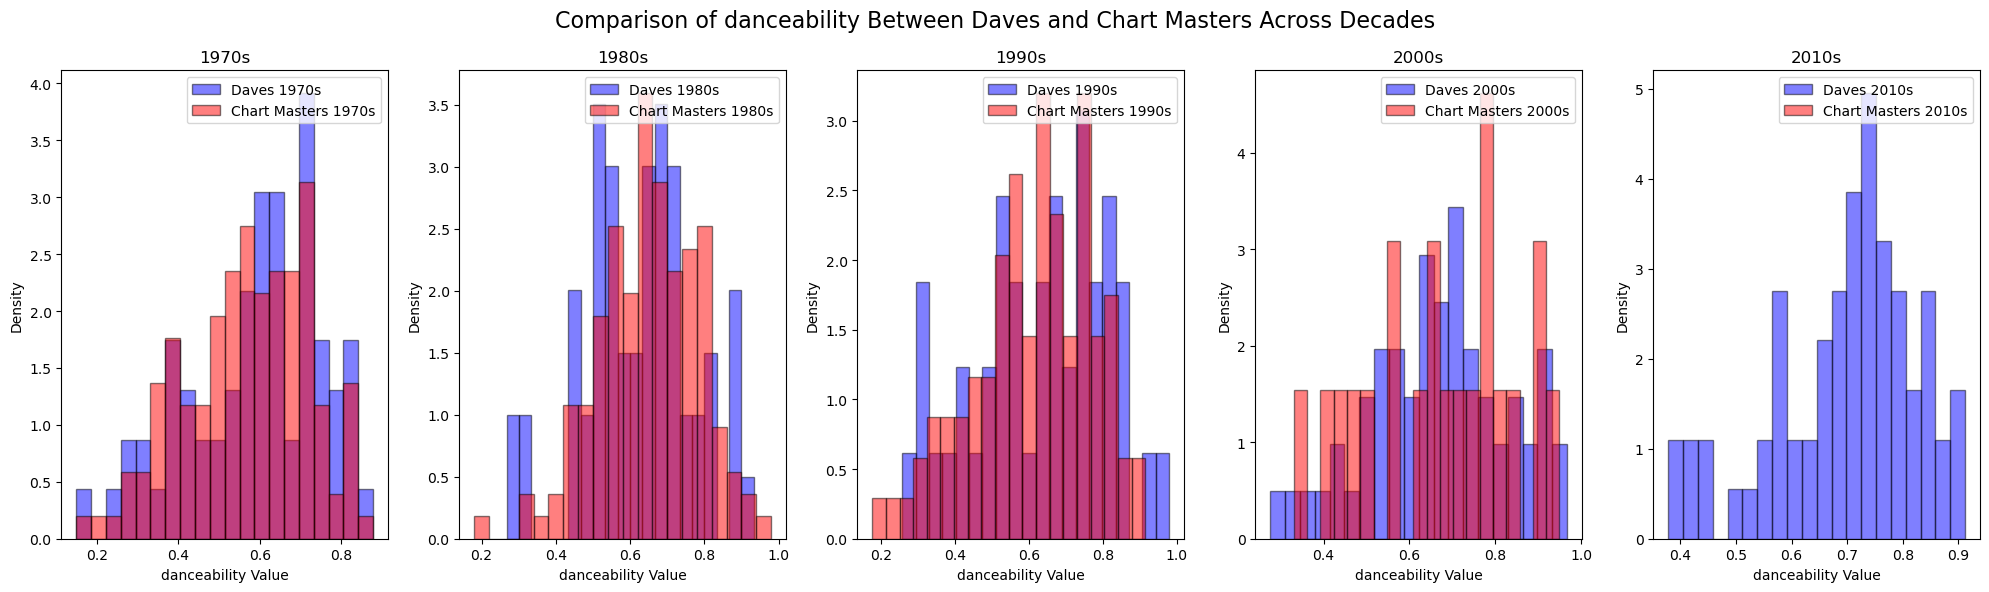

In [150]:
# Danceability
compare_song_element('danceability', dfs, chart_masters_dfs)

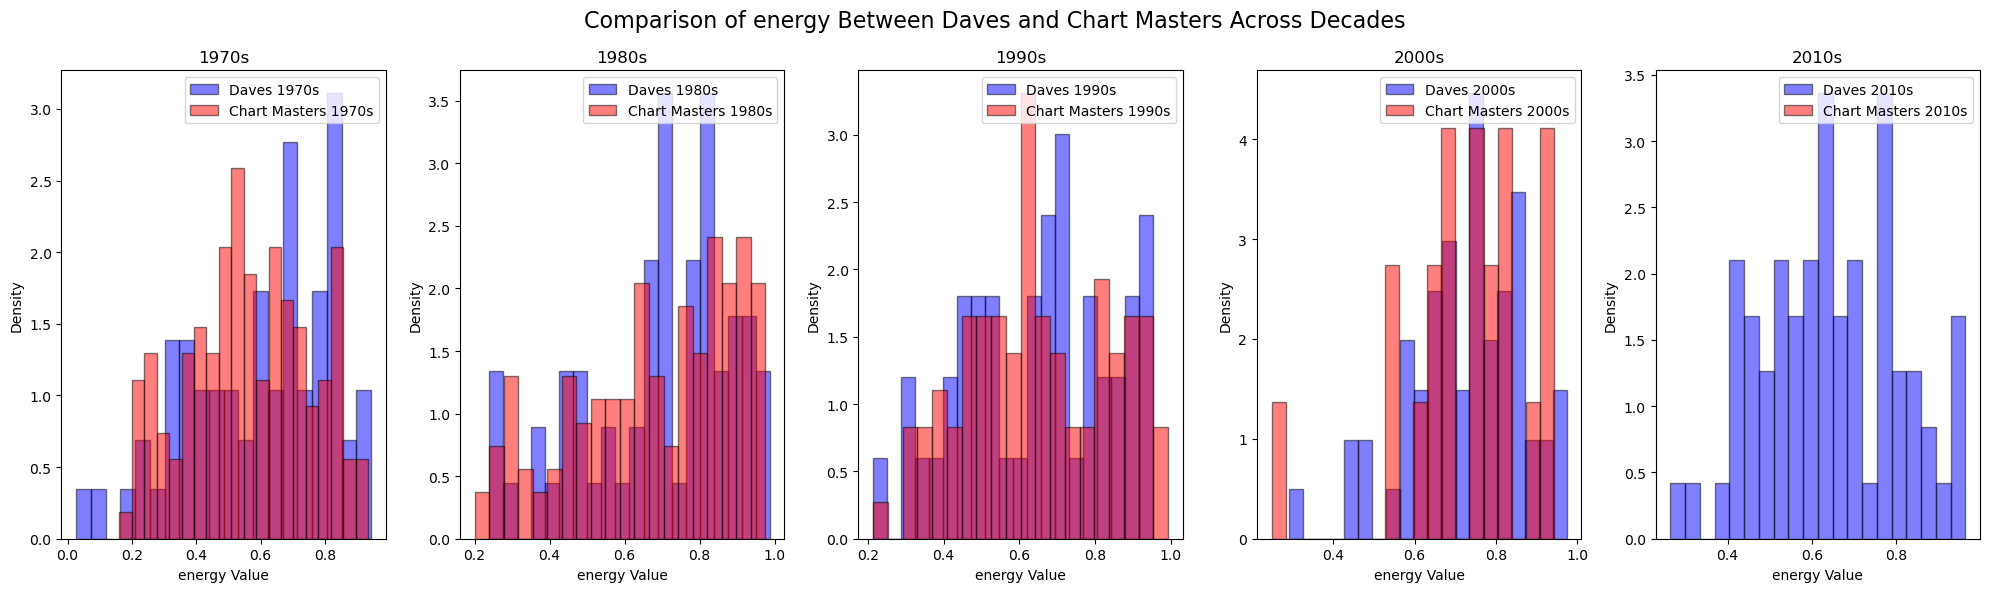

In [152]:
# Energy
compare_song_element('energy', dfs, chart_masters_dfs)

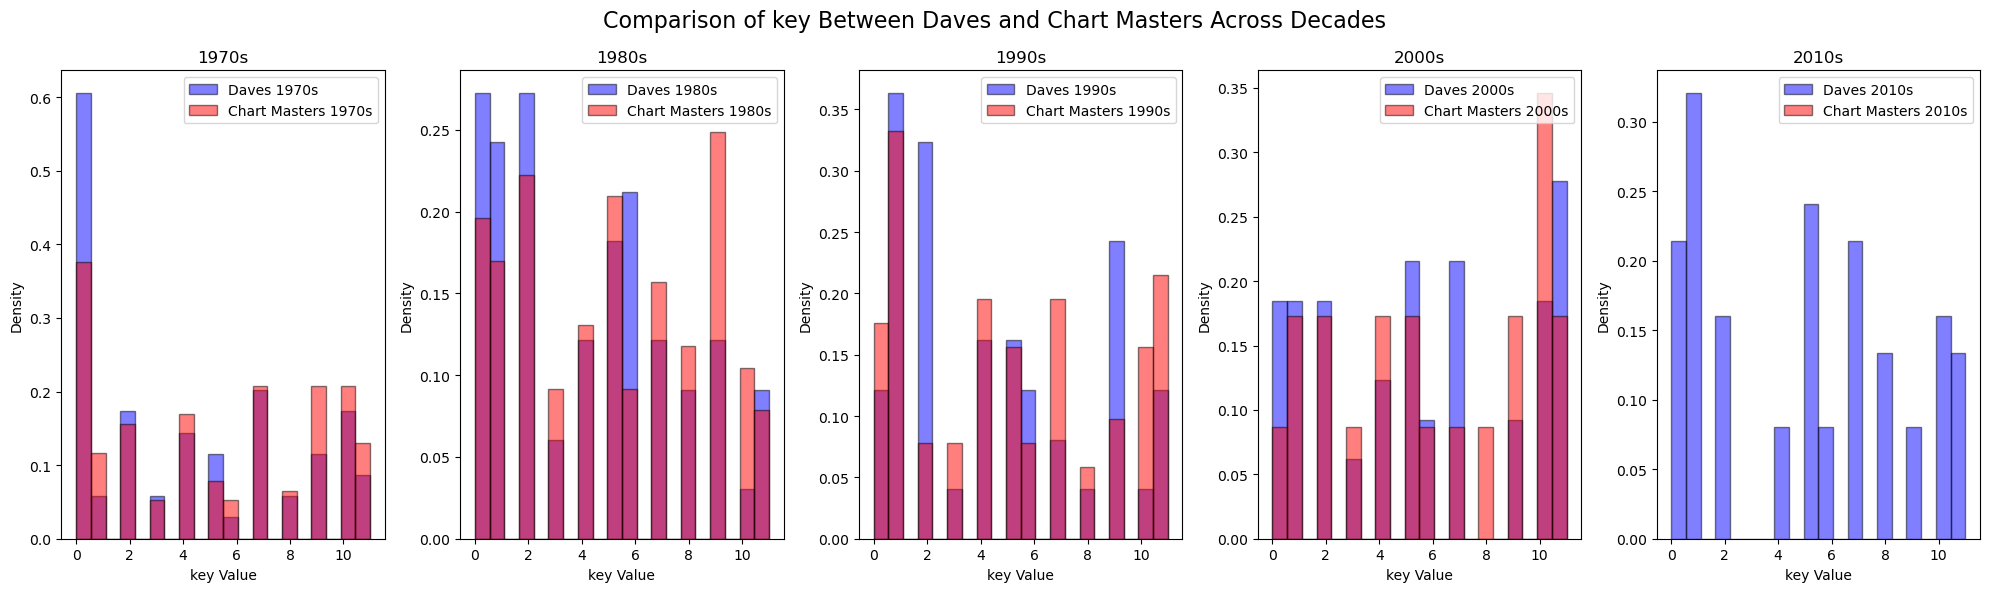

In [154]:
# Key
compare_song_element('key', dfs, chart_masters_dfs)

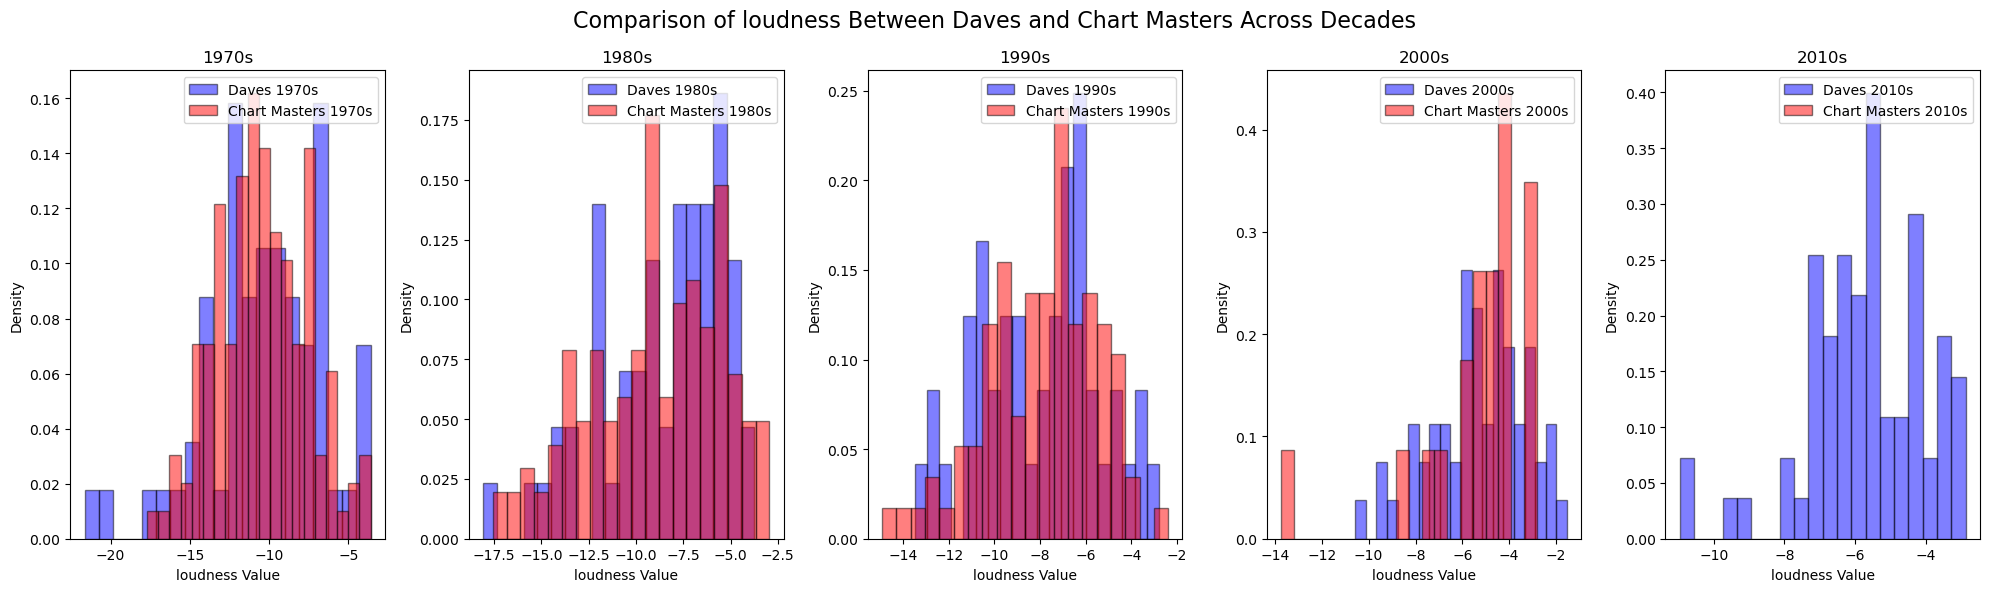

In [156]:
# Loudness
compare_song_element('loudness', dfs, chart_masters_dfs)

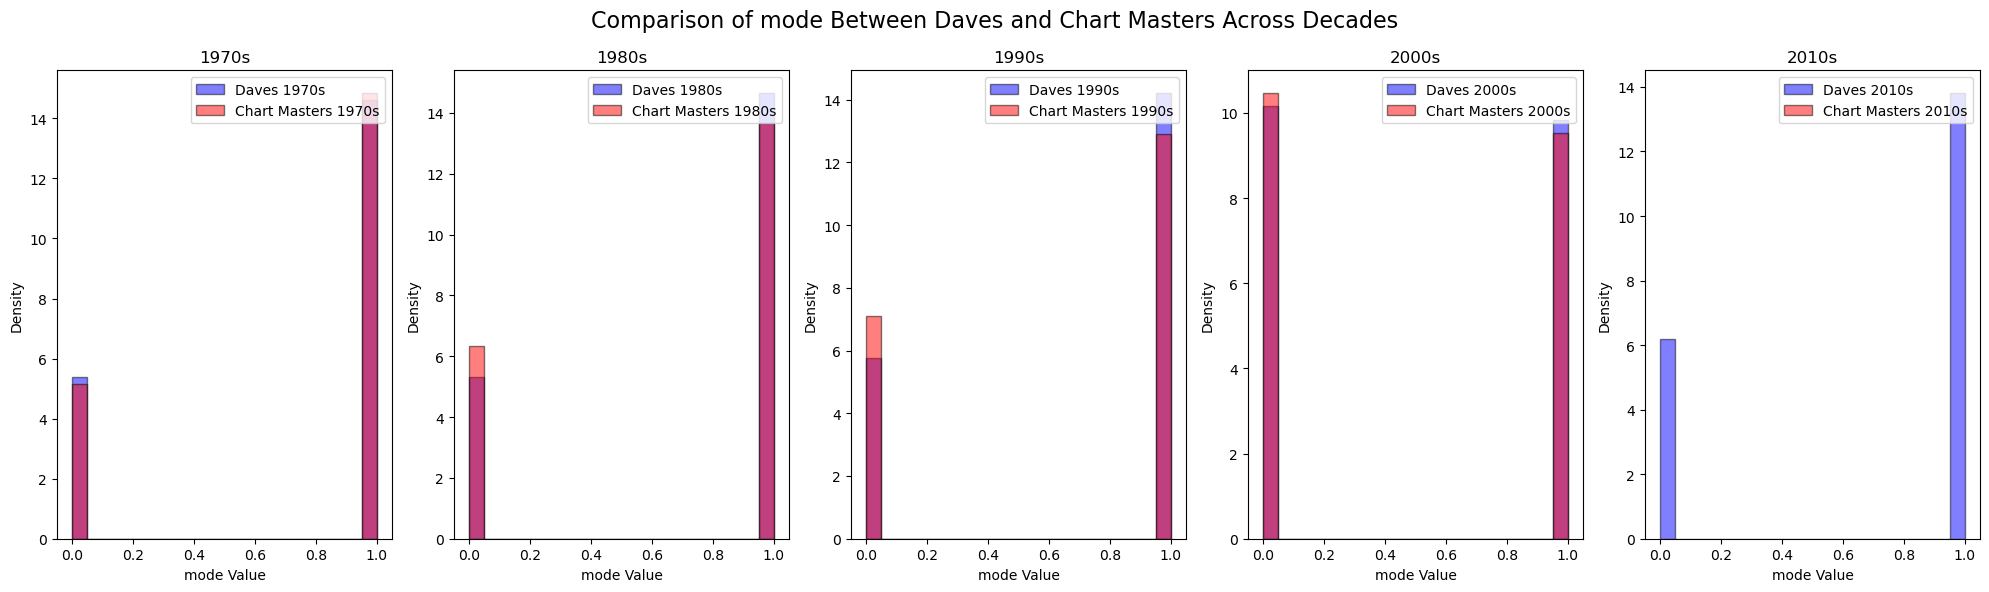

In [158]:
# Mode
compare_song_element('mode', dfs, chart_masters_dfs)

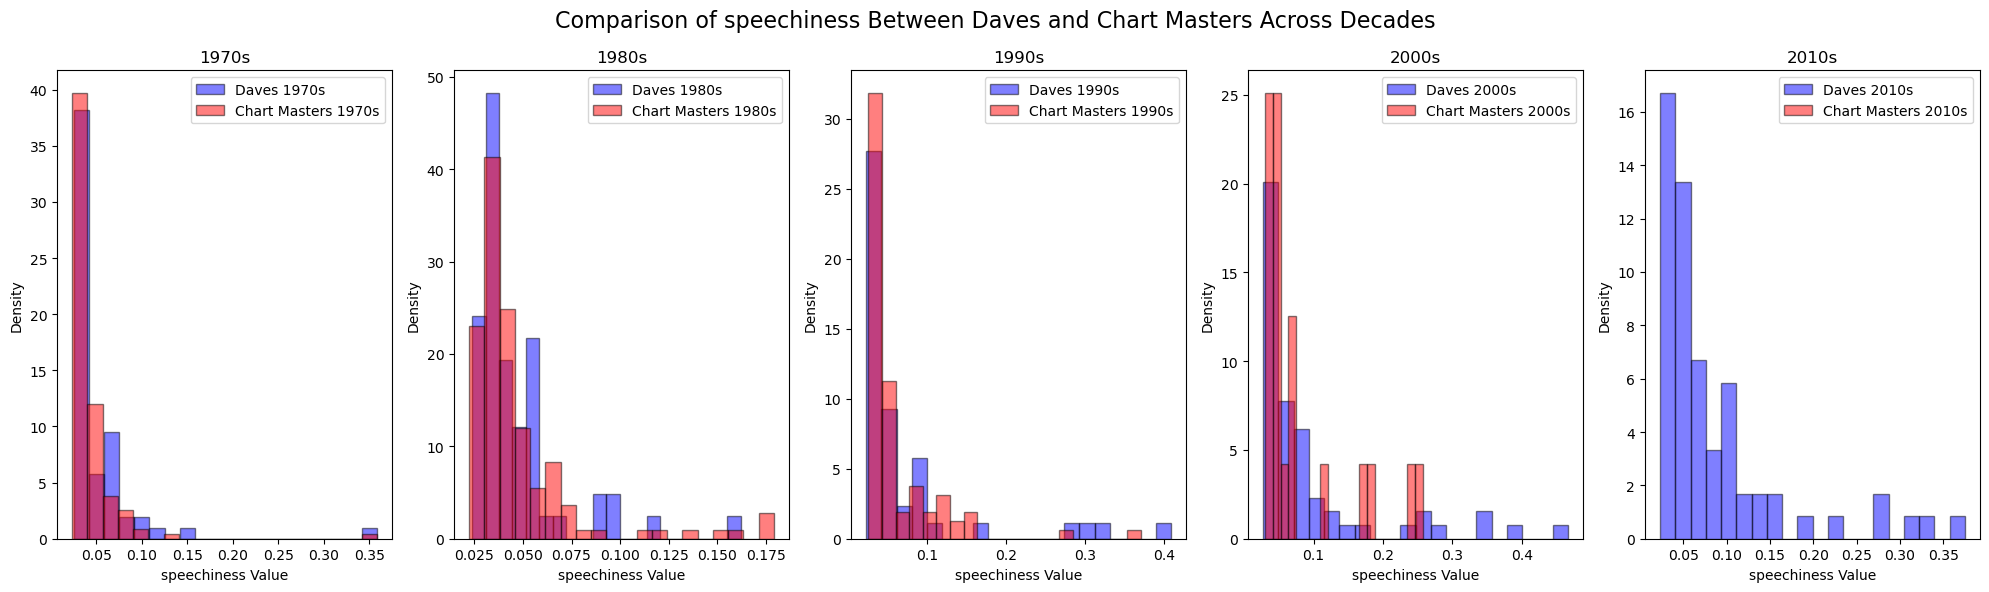

In [160]:
# Speechiness
compare_song_element('speechiness', dfs, chart_masters_dfs)

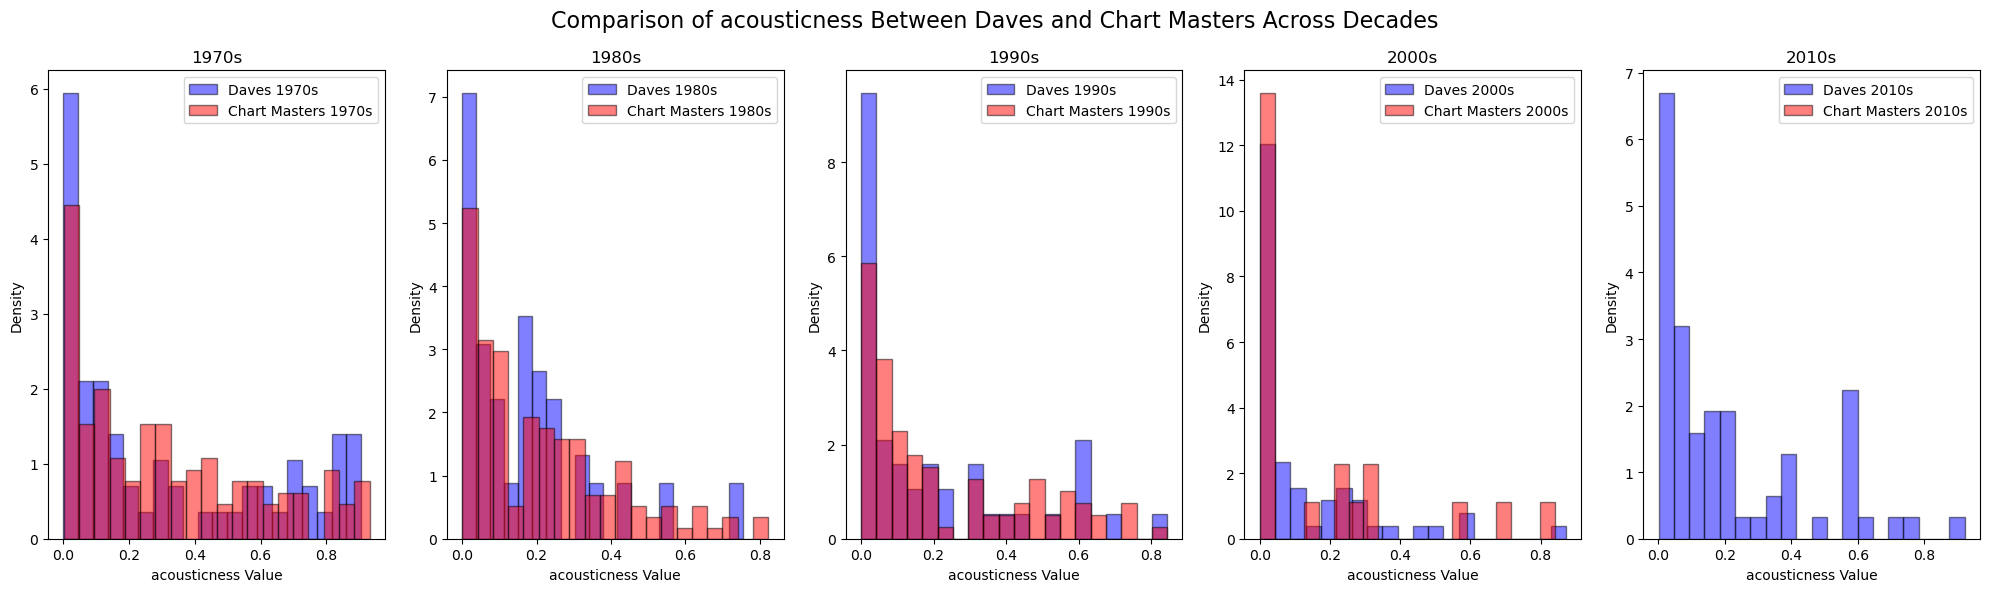

In [162]:
# acousticness
compare_song_element('acousticness', dfs, chart_masters_dfs)

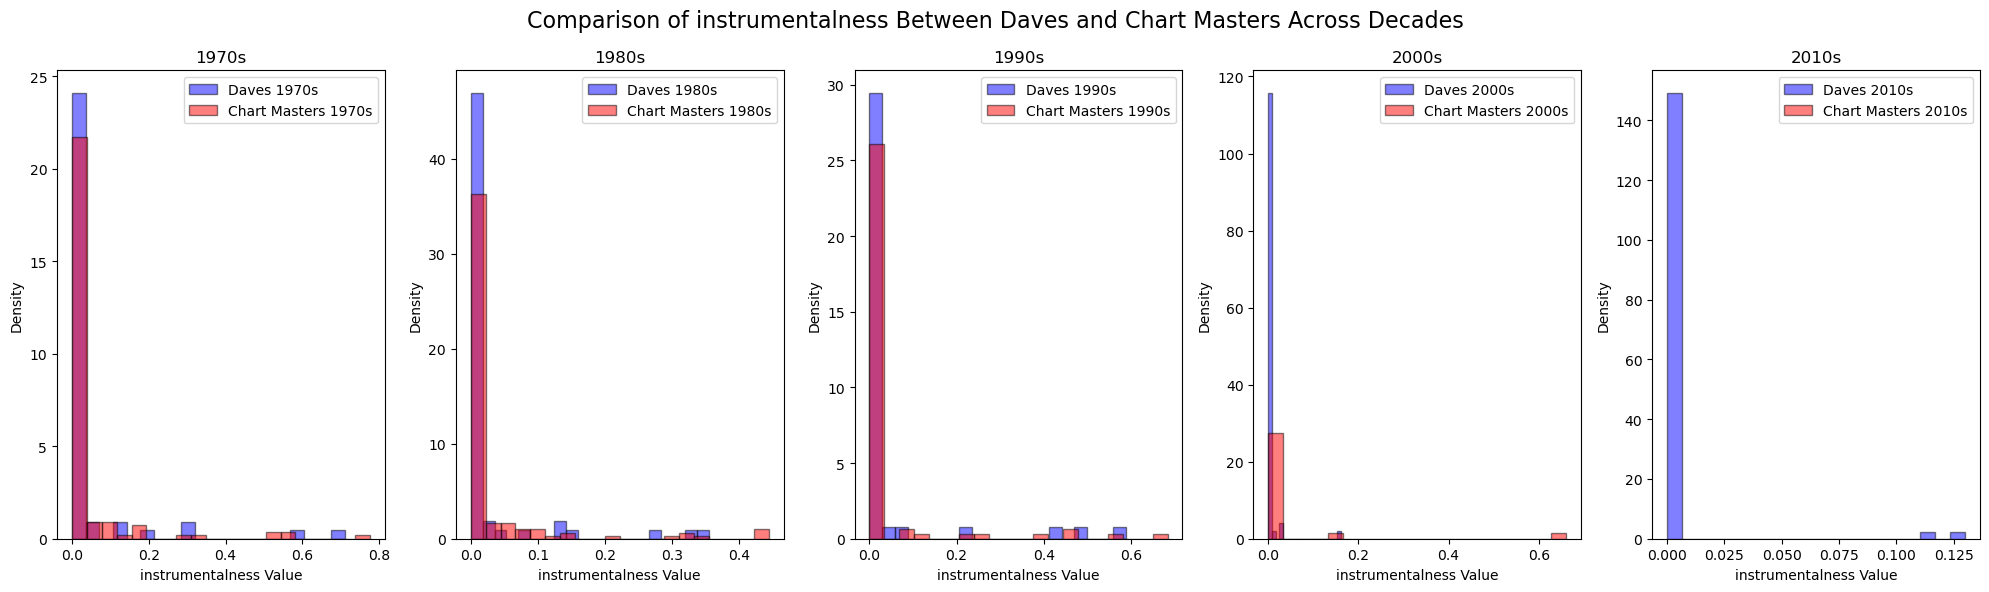

In [164]:
# instrumentalness
compare_song_element('instrumentalness', dfs, chart_masters_dfs)

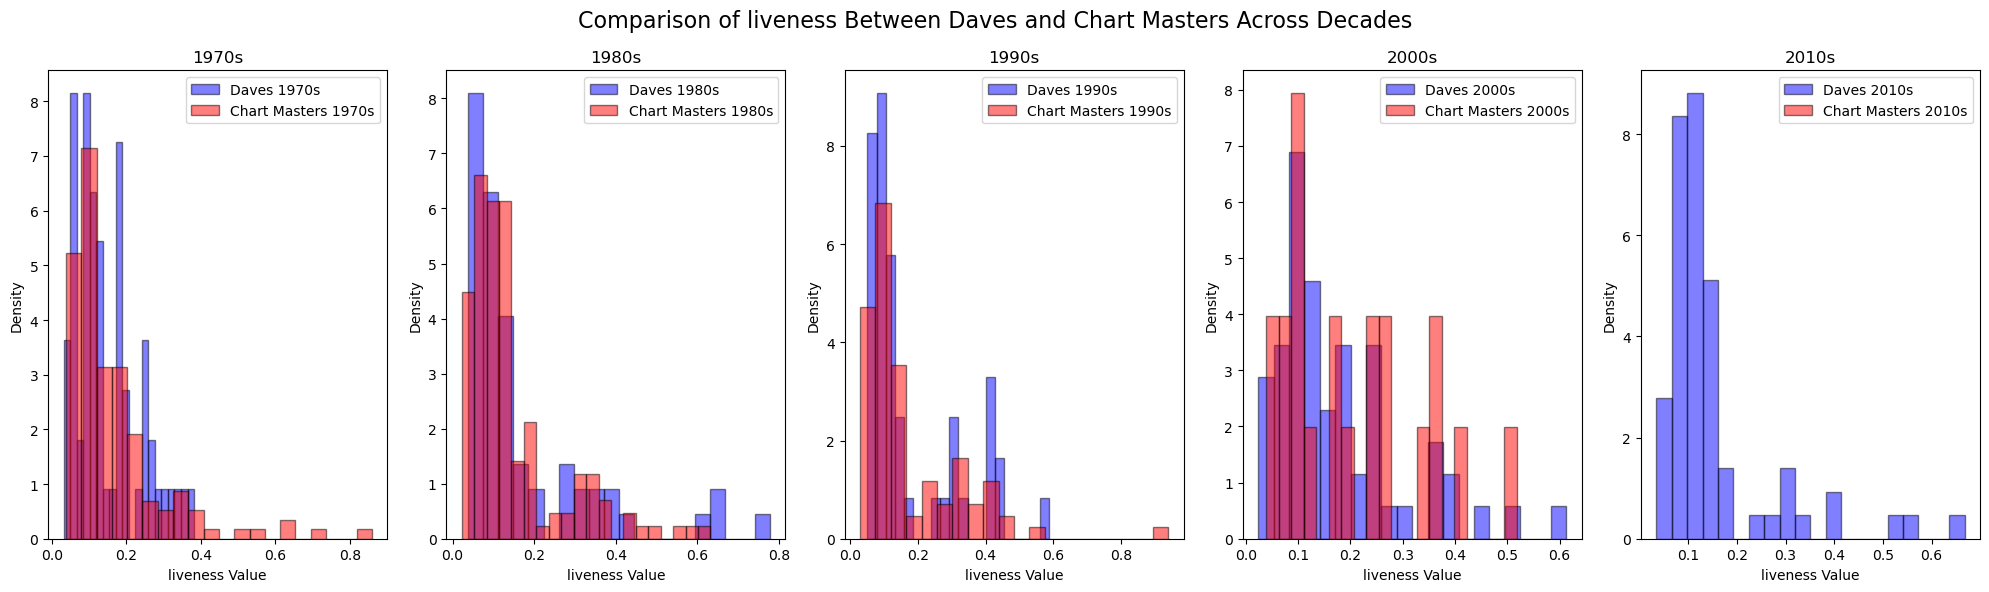

In [166]:
# liveness
compare_song_element('liveness', dfs, chart_masters_dfs)

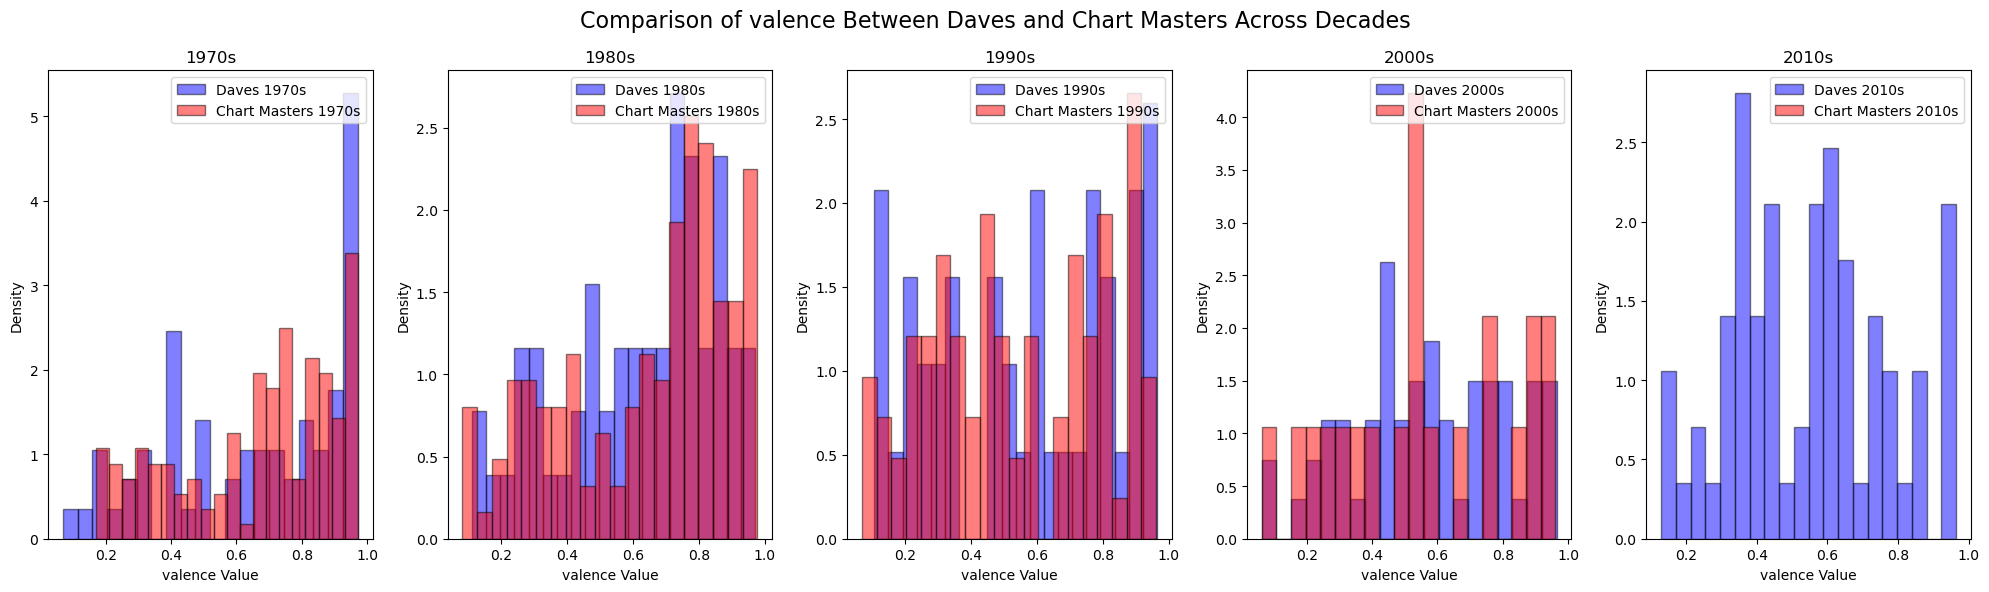

In [168]:
# valence
compare_song_element('valence', dfs, chart_masters_dfs)

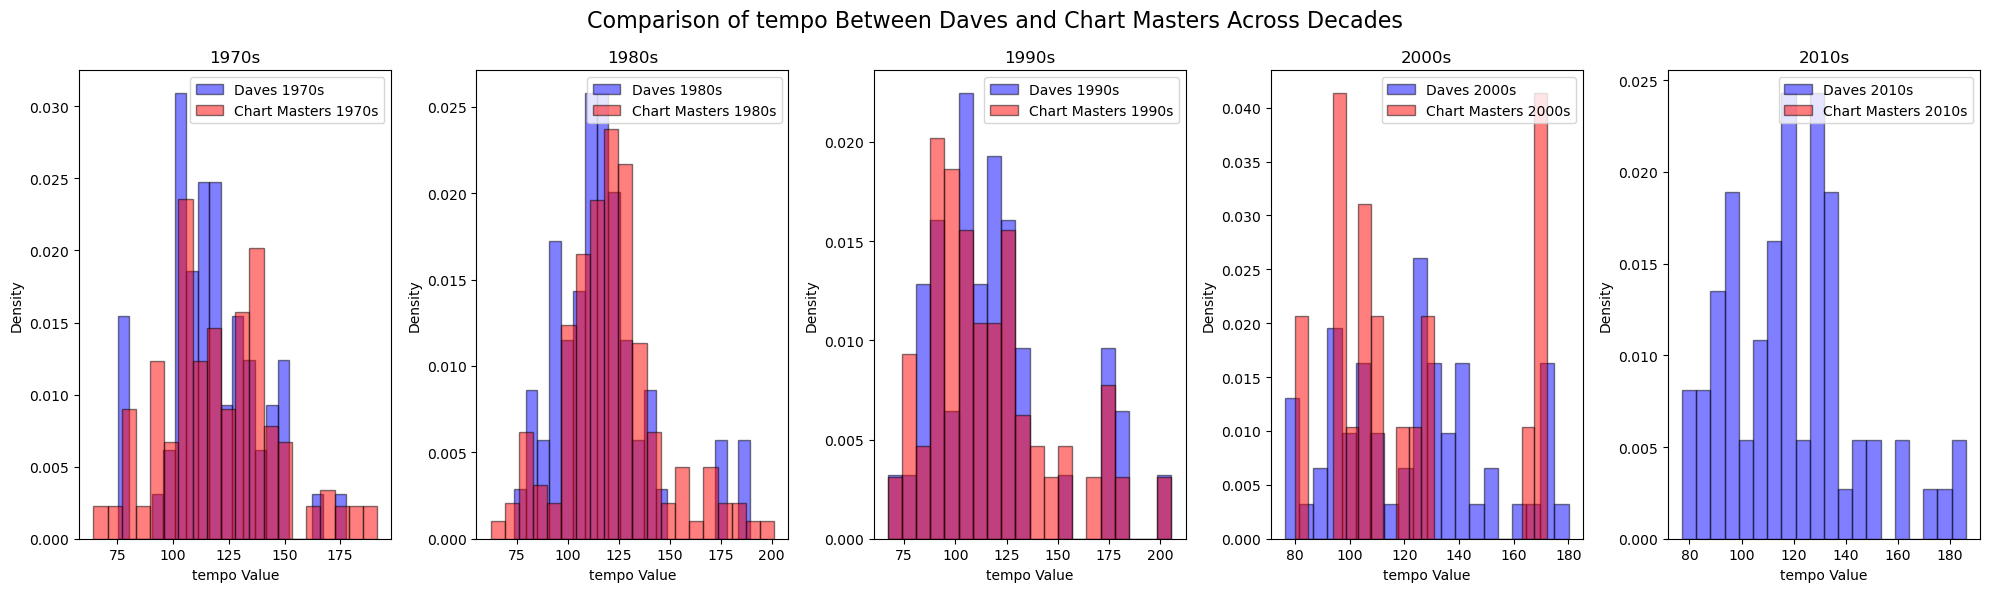

In [170]:
# tempo
compare_song_element('tempo', dfs, chart_masters_dfs)

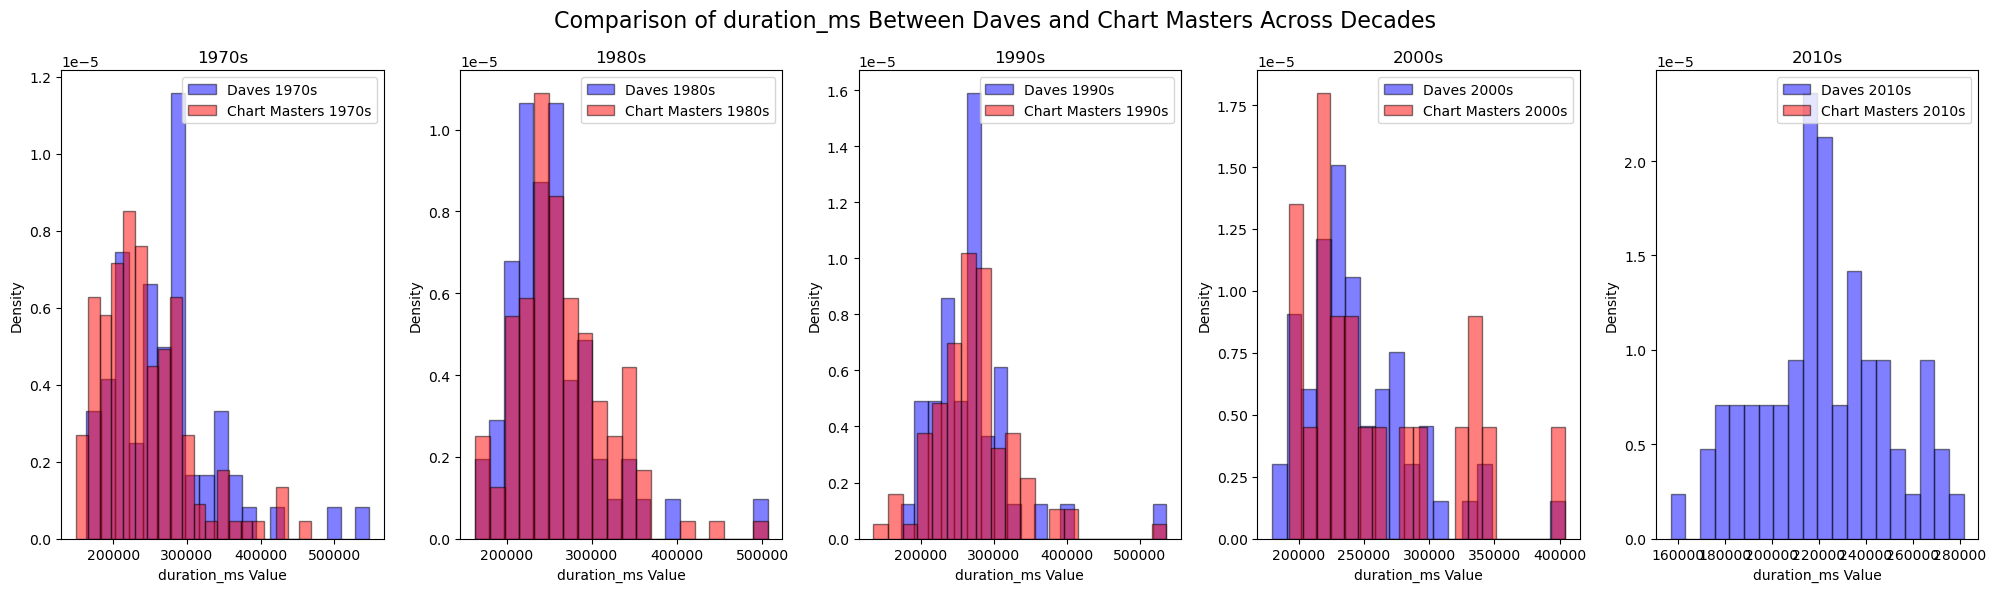

In [172]:
# duration
compare_song_element('duration_ms', dfs, chart_masters_dfs)

## Retreive Top 100 1970s Songs from Dave's Music Database

In [4]:
# full 1970s songs

# Set up a cached session
session = requests_cache.CachedSession()

# 1970s url
dave_1970_url = 'https://davesmusicdatabase.blogspot.com/2014/08/top-songs-from-1970-1979.html'
time.sleep(0.05)

# Get request
r1 = session.get(dave_1970_url)
r1.raise_for_status()

# Navigate all the songs in the a tags
html1 = lx.fromstring(r1.text)
artist_songs_1970s = html1.xpath('//p//a/text() | //p/text()')

# Drop the extra text in the beginning and end
artist_songs_1970s_ = artist_songs_1970s[4:-6]

# Clean up the list, get rid of whitespace charcters
# Remove extra text in the beginning and end
cleaned_text_1970s = ' '.join(artist_songs_1970s_)
cleaned_text_1970s = ' '.join(cleaned_text_1970s.split())
rankings_start_1970s = cleaned_text_1970s.find("1.")  # Find the start of the rankings
rankings_text_1970s = cleaned_text_1970s[rankings_start_1970s:]

# Split on ranking
# Remove extra space in quotations
songs_1970s = re.split(r'\d+\.', rankings_text_1970s)
cleaned_songs_1970s = [song.strip().replace("“ ", "“").replace(" ”", "”") for song in songs_1970s if song.strip()]

# Create a list of tuples with (song title, artist)
# Extract the song title between the double quotations
# Extract the artist which comes before "
formatted_songs_70s = [(song.split('“')[1].split('”')[0], song.split('“')[0].strip()) for song in cleaned_songs_1970s]
formatted_songs_70s

[('Bohemian Rhapsody', 'Queen'),
 ('Imagine', 'John Lennon'),
 ('Stayin’ Alive', 'Bee Gees'),
 ('Bridge Over Troubled Water', 'Simon & Garfunkel'),
 ('Hotel California', 'Eagles'),
 ('American Pie', 'Don McLean'),
 ('Stairway to Heaven', 'Led Zeppelin'),
 ('Let It Be', 'The Beatles'),
 ('Layla', 'Derek & the Dominos'),
 ('Superstition', 'Stevie Wonder'),
 ('I Will Survive', 'Gloria Gaynor'),
 ('Dancing Queen', 'Abba'),
 ('Another Brick in the Wall Part II', 'Pink Floyd'),
 ('Born to Run', 'Bruce Springsteen'),
 ('What’s Going On', 'Marvin Gaye'),
 ('Maggie May', 'Rod Stewart'),
 ('Your Song', 'Elton John'),
 ('Let’s Stay Together', 'Al Green'),
 ('Heart of Glass', 'Blondie'),
 ('Le Freak', 'Chic'),
 ('My Sweet Lord', 'George Harrison'),
 ('London Calling', 'The Clash'),
 ('Sweet Home Alabama', 'Lynyrd Skynyrd'),
 ('Y.M.C.A.', 'Village People'),
 ('Let’s Get It On', 'Marvin Gaye'),
 ('How Deep Is Your Love', 'Bee Gees'),
 ('You’re the One That I Want', 'Olivia Newton-John & John Travolt

## Retreive Top 100 1980s Songs from Dave's Music Database

In [6]:
# full 80's songs

# Set up a cached session
session = requests_cache.CachedSession()

# 80s url
dave_1980_url = 'https://davesmusicdatabase.blogspot.com/2014/08/top-100-songs-from-1980-to-1989.html'
time.sleep(0.05)

# Get request
r2 = session.get(dave_1980_url)
r2.raise_for_status()

# Navigate all the songs in the a tags
# Remove beginning and ending message
html2 = lx.fromstring(r2.text)
artist_songs_80s = html2.xpath('//p//a/text() | //p/text()')
artist_songs_80s_ = artist_songs_80s[10:-4]

# Clean up the list, get rid of whitespace charcters
# Remove extra text in the beginning and end
cleaned_text_80s = ' '.join(artist_songs_80s_)
cleaned_text_80s = ' '.join(cleaned_text_80s.split())

# Find the start of the rankings
rankings_start_80s = cleaned_text_80s.find("1.")
rankings_text_80s = cleaned_text_80s[rankings_start_80s:]

# split songs based on ranking
# use list generator to remove extra spaces
songs_80s = re.split(r'\d+\.', rankings_text_80s)
cleaned_songs_80s = [song.strip().replace("“ ", "“").replace(" ”", "”") for song in songs_80s if song.strip()]
#cleaned_songs_80s

# Create a list of tuples with (song title, artist)
# Extract the song title between the double quotations
# Extract the artist which comes before "
formatted_songs_80s = [(song.split('“')[1].split('”')[0], song.split('“')[0].strip()) for song in cleaned_songs_80s]
formatted_songs_80s

[('Billie Jean', 'Michael Jackson'),
 ('Every Breath You Take', 'The Police'),
 ('Sweet Child O’ Mine', 'Guns N’ Roses'),
 ('When Doves Cry', 'Prince'),
 ('I Love Rock and Roll', 'Joan Jett & the Blackhearts'),
 ('With or Without You', 'U2'),
 ('Livin’ on a Prayer', 'Bon Jovi'),
 ('Endless Love', 'Lionel Richie & Diana Ross'),
 ('Jump', 'Van Halen'),
 ('Beat It', 'Michael Jackson'),
 ('You Shook Me All Night Long', 'AC/DC'),
 ('Love Will Tear Us Apart', 'Joy Division'),
 ('Don’t Stop Believin’', 'Journey'),
 ('Eye of the Tiger', 'Survivor'),
 ('We Are the World', 'U.S.A. for Africa'),
 ('Don’t You Want Me?', 'The Human League'),
 ('Like a Prayer', 'Madonna'),
 ('Tainted Love', 'Soft Cell'),
 ('I Wanna Dance with Somebody Who Loves Me', 'Whitney Houston'),
 ('Bette Davis Eyes', 'Kim Carnes'),
 ('Another One Bites the Dust', 'Queen'),
 ('Celebration', 'Kool & the Gang'),
 ('Take on Me', 'Aha'),
 ('Call Me', 'Blondie'),
 ('Blue Monday', 'New Order'),
 ('I Still Haven’t Found What I’m Look

## Retreive Top 100 1990s Songs from Dave's Music Database

In [8]:
# full 90s songs

# 90s url
dave_1990_url = 'https://davesmusicdatabase.blogspot.com/2014/08/top-songs-from-1990-to-1999.html'
time.sleep(0.05)

# Get request
r3 = session.get(dave_1990_url)
r3.raise_for_status()

# Navigate all the songs in the a tags
html3 = lx.fromstring(r3.text)
artist_songs_90s = html3.xpath('//p//a/text() | //p/text()')

# Clean up the list, get rid of whitespace charcters
# Remove extra text in the beginning and end
cleaned_text_90s = ' '.join(artist_songs_90s)
cleaned_text_90s = ' '.join(cleaned_text_90s.split())
rankings_start_90s = cleaned_text_90s.find("1.")  # Find the start of the rankings
rankings_text_90s = cleaned_text_90s[rankings_start_90s:]

# Split on ranking
# Remove extra space in quotations
songs_90s = re.split(r'\d+\.', rankings_text_90s)
cleaned_songs_90s = [song.strip().replace("“ ", "“").replace(" ”", "”") for song in songs_90s if song.strip()]
#cleaned_songs_90s

# Create a list of tuples with (song title, artist)
# Extract the song title between the double quotations
# Extract the artist which comes before "
formatted_songs_90s = [(song.split('“')[1].split('”')[0], song.split('“')[0].strip()) for song in cleaned_songs_90s]
formatted_songs_90s

[('I Will Always Love You', 'Whitney Houston'),
 ('Smells Like Teen Spirit', 'Nirvana'),
 ('(Everything I Do) I Do It for You', 'Bryan Adams'),
 ('Nothing Compares 2 U', 'Sinéad O’Connor'),
 ('My Heart Will Go On', 'Celine Dion'),
 ('Losing My Religion', 'R.E.M.'),
 ('Candle in the Wind 1997 (Goodbye England’s Rose)', 'Elton John'),
 ('Wonderwall', 'Oasis'),
 ('Macarena (Bayside Boys Mix)', 'Los Del Rio'),
 ('One', 'U2'),
 ('Gangsta’s Paradise', 'Coolio with L.V.'),
 ('Creep', 'Radiohead'),
 ('Baby One More Time', 'Britney Spears'),
 ('Bitter Sweet Symphony', 'The Verve'),
 ('Wannabe', 'Spice Girls'),
 ('Under the Bridge', 'Red Hot Chili Peppers'),
 ('Smooth', 'Santana with Rob Thomas'),
 ('I Don’t Want to Miss a Thing', 'Aerosmith'),
 ('I’ll Make Love to You', 'Boyz II Men'),
 ('All I Want for Christmas Is You', 'Mariah Carey'),
 ('Iris', 'Goo Goo Dolls'),
 ('I’ll Be Missing You', 'Puff Daddy with Faith Evans & 112'),
 ('Believe', 'Cher'),
 ('You’re Still the One', 'Shania Twain'),
 (

## Retreive Top 100 2000s Songs Dave's Music Database

In [10]:
# full 2000s songs

# 2000s url
dave_2000_url = 'https://davesmusicdatabase.blogspot.com/2017/10/the-top-100-songs-from-2000-2009.html'
time.sleep(0.05)

# Get request
r4 = session.get(dave_2000_url)
r4.raise_for_status()

# Navigate all the songs in the a tags
html4 = lx.fromstring(r4.text)
artist_songs_2000s = html4.xpath('//p//a/text() | //p/text()')

# Drop the extra text in the beginning and end
artist_songs_2000s_ = artist_songs_2000s[4:-18]
artist_songs_2000s_

# Clean up the list, get rid of whitespace charcters
# Remove extra text in the beginning and end
cleaned_text_2000s = ' '.join(artist_songs_2000s_)
cleaned_text_2000s = ' '.join(cleaned_text_2000s.split())
rankings_start_2000s = cleaned_text_2000s.find("1.")  # Find the start of the rankings
rankings_text_2000s = cleaned_text_2000s[rankings_start_2000s:]

# Split on ranking
# Remove extra space in quotations
songs_2000s = re.split(r'\d+\.', rankings_text_2000s)
cleaned_songs_2000s = [song.strip().replace("“ ", "“").replace(" ”", "”") for song in songs_2000s if song.strip()]

# Create a list of tuples with (song title, artist)
# Extract the song title between the double quotations
# Extract the artist which comes before "
formatted_songs_2000s = [(song.split('“')[1].split('”')[0], song.split('“')[0].strip()) for song in cleaned_songs_2000s]
formatted_songs_2000s

[('Hey Ya!', 'OutKast'),
 ('I Gotta Feeling', 'Black Eyed Peas'),
 ('Lose Yourself', 'Eminem'),
 ('Yeah!', 'Usher with Lil’ Jon & Ludacris'),
 ('Crazy in Love', 'Beyoncé with Jay-Z'),
 ('Crazy', 'Gnarls Barkley'),
 ('Single Ladies (Put a Ring on It)', 'Beyoncé'),
 ('Umbrella', 'Rihanna with Jay-Z'),
 ('Low', 'Flo Rida with T-Pain'),
 ('We Belong Together', 'Mariah Carey'),
 ('Viva La Vida', 'Coldplay'),
 ('Poker Face', 'Lady Gaga'),
 ('Boom Boom Pow', 'Black Eyed Peas'),
 ('Tik Tok', 'Ke$ha'),
 ('Gold Digger', 'Kanye West with Jamie Foxx'),
 ('Bleeding Love', 'Leona Lewis'),
 ('Just Dance', 'Lady Gaga with Colby O’Donnis'),
 ('I’m Yours', 'Jason Mraz'),
 ('In Da Club', '50 Cent'),
 ('Irreplaceable', 'Beyoncé'),
 ('Sexyback', 'Justin Timberlake'),
 ('Hips Don’t Lie', 'Shakira with Wyclef Jean'),
 ('Hot in Herre', 'Nelly'),
 ('Fallin’', 'Alicia Keys'),
 ('You’re Beautiful', 'James Blunt'),
 ('No One', 'Alicia Keys'),
 ('Can’t Get You Out of My Head', 'Kylie Minogue'),
 ('I Kissed a Girl'

## Retreive Top 100 2010s Songs from Dave's Music Database

In [12]:
# full 2010s songs

# 2010s url
dave_2010_url = 'https://davesmusicdatabase.blogspot.com/2017/10/the-top-50-songs-from-2010-2016.html'
time.sleep(0.05)

# Get request
r5 = session.get(dave_2010_url)
r5.raise_for_status()

# Navigate all the songs in the a tags
html5 = lx.fromstring(r5.text)
artist_songs_2010s = html5.xpath('//p//a/text() | //p/text()')

# Drop the extra text in the beginning and end
artist_songs_2010s_ = artist_songs_2010s[5:-5]

# Clean up the list, get rid of whitespace charcters
# Remove extra text in the beginning and end
cleaned_text_2010s = ' '.join(artist_songs_2010s_)
cleaned_text_2010s = ' '.join(cleaned_text_2010s.split())
rankings_start_2010s = cleaned_text_2010s.find("1.")  # Find the start of the rankings
rankings_text_2010s = cleaned_text_2010s[rankings_start_2010s:]

# Split on ranking
# Remove extra space in quotations
songs_2010s = re.split(r'\d+\.', rankings_text_2010s)
cleaned_songs_2010s = [song.strip().replace("“ ", "“").replace(" ”", "”") for song in songs_2010s if song.strip()]

# Create a list of tuples with (song title, artist)
# Extract the song title between the double quotations
# Extract the artist which comes before "
formatted_songs_2010s = [(song.split('“')[1].split('”')[0], song.split('“')[0].strip()) for song in cleaned_songs_2010s]
formatted_songs_2010s

[('Uptown Funk!', 'Mark Ronson with Bruno Mars'),
 ('Rolling in the Deep', 'Adele'),
 ('Shape of You', 'Ed Sheeran'),
 ('Happy', 'Pharrell Williams'),
 ('Somebody That I Used to Know', 'Gotye with Kimbra'),
 ('Despacito', 'Luis Fonsi with Daddy Yankee & Justin Bieber'),
 ('Call Me Maybe', 'Carly Rae Jepsen'),
 ('Blurred Lines', 'Robin Thicke with T.I. & Pharrell Williams'),
 ('Old Town Road', 'Lil Nas X with Billy Ray Cyrus'),
 ('Hello', 'Adele'),
 ('We Found Love', 'Rihanna with Calvin Harris'),
 ('Party Rock Anthem', 'LMFAO with Lauren Bennett & GoonRock'),
 ('Closer', 'The Chainsmokers with Halsey'),
 ('Blinding Lights', 'The Weeknd'),
 ('Royals', 'Lorde'),
 ('Thinking Out Loud', 'Ed Sheeran'),
 ('See You Again', 'Wiz Khalifa with Charlie Puth'),
 ('Perfect', 'Ed Sheeran with Beyoncé'),
 ('Just the Way You Are (Amazing)', 'Bruno Mars'),
 ('Moves Like Jagger', 'Maroon 5 with Christina Aguilera'),
 ('Someone Like You', 'Adele'),
 ('Shake It Off', 'Taylor Swift'),
 ('Love the Way You L

# Retrieve and Sort ChartMasters Top 100 Songs per Decade by Physical Sales

In [14]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()  

def clean_total_sales(value):
    value = str(value).replace(',', '').replace(' ', '')
    try:
        return float(value)
    except ValueError:
        return 0

# API URL
url = 'https://chartmasters.org/wp-admin/admin-ajax.php?action=get_wdtable&table_id=34&wdt_var1=1Mxqyy3pSjf8kZZL4QVxS0'

session = requests_cache.CachedSession()

# Function to fetch data based on a dynamic year range (1970 to 2029)
def fetch_data_for_year_range(start_year, end_year, start_row=0, length=100):
    params = {
        'action': 'get_wdtable',
        'table_id': '34',
        'wdt_var1': '1Mxqyy3pSjf8kZZL4QVxS0'  # Static part of the URL
    }

    data = {
        'draw': '12', #'9' may need to change when running cell for the first time,
        'columns[0][data]': '0',  # Rank
        'columns[1][data]': '1',  # Song
        'columns[2][data]': '2',  # Year
        'columns[3][data]': '3',  # Artist
        'columns[4][data]': '4',  # Total Sales
        'order[0][column]': '0',   # Sorting by rank
        'order[0][dir]': 'asc',
        'start': str(start_row),
        'length': str(length),  # Get top 100 rows
        'wdtNonce': 'ce06eace71', #'50bcd6afea' may need to change when running cell for the first time
        'columns[2][search][value]': f'{start_year}|{end_year}',  # year filtering
        'columns[2][search][regex]': 'false',
    }

    # Send POST request
    response = session.post(url, params=params, data=data)

    if response.status_code == 200:
        jsonData = response.json()

        if 'data' in jsonData:
            song_name = []
            artist = []
            year = []
            total_sales = []

            for row in jsonData['data']:
                time.sleep(0.05)
                song = remove_html_tags(row[1])  # Song Name (2nd item)
                artist_name = remove_html_tags(row[3])  # Artist (4th item)
                song_name.append(song)
                artist.append(artist_name)
                year.append(row[2])  # Year (3rd item)
                total_sales.append(clean_total_sales(row[4]))  # Total Sales (5th item)

            # Create DataFrame with the required columns
            df = pd.DataFrame({
                'Song Name': song_name,
                'Artist': artist,
                'Year': year,
                'Total Sales': total_sales
            })

            # Return the DataFrame
            return df
        else:
            print(f"No data found for {start_year}-{end_year}.")
            return pd.DataFrame()  # Return an empty DataFrame if no data
    else:
        print(f"Failed to fetch data. Status Code: {response.status_code}")
        return pd.DataFrame()

# List to hold data from multiple decades
all_data = []

# Fetch data for different decades, handling pagination to ensure only 100 songs per decade
for start_year, end_year in [(1970, 1979), (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2019), (2020, 2029)]:
    start_row = 0
    length = 100
    while True:
        df = fetch_data_for_year_range(start_year, end_year, start_row, length)
        if not df.empty:
            all_data.append(df)
            start_row += length  # Move to the next page (next 100 rows)
        else:
            break  # Break out of the loop if no more data is found

# Concatenate all data into one DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Ensure the 'Year' column is treated as a numeric type (integer)
final_df['Year'] = pd.to_numeric(final_df['Year'], errors='coerce')

# Ensure 'Total Sales' is a numeric value/ float
final_df['Total Sales'] = pd.to_numeric(final_df['Total Sales'], errors='coerce')

# Remove duplicates based on 'Song Name', 'Artist', and 'Year'
final_df = final_df.drop_duplicates(subset=['Song Name', 'Artist', 'Year'])

# limit time frame from 1970 to 2029 (current decade)
final_df = final_df[(final_df['Year'] >= 1970) & (final_df['Year'] <= 2029)]

# Sort by year to ensure it's ordered by year, and reset the index for a clean output
final_df = final_df.sort_values(by='Year').reset_index(drop=True)

# Format the 'Total Sales' column for better readability
final_df['Total Sales'] = final_df['Total Sales'].apply(lambda x: f'{x:,.0f}')

# Print the final output in the desired format: ('year', 'song name', 'artist name', 'total sales')
for index, row in final_df.iterrows():
    print(f"('{row['Year']}', '{row['Song Name']}', '{row['Artist']}', '{row['Total Sales']}')")


/var/folders/18/424s2_hs29n7q2lc4y6hbjch0000gn/T/ipykernel_15797/4249807875.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


('1970', '(They Long To Be) Close To You', 'Carpenters', '3,763,000')
('1970', 'Your Song', 'Elton John', '1,090,000')
('1970', 'Cecilia', 'Simon & Garfunkel', '2,030,000')
('1970', 'Mama's Pearl', 'The Jackson 5', '1,670,000')
('1970', 'The Wonder Of You', 'Elvis Presley', '2,100,000')
('1970', 'Have You Ever Seen The Rain', 'Creedence Clearwater Revival', '2,111,250')
('1970', 'Bridge over Troubled Water', 'Simon & Garfunkel', '4,160,000')
('1970', 'Don't Play That Song (You Lied)', 'Aretha Franklin', '1,303,500')
('1970', 'Up Around The Bend', 'Creedence Clearwater Revival', '1,458,500')
('1970', 'Instant Karma!', 'John Lennon', '3,037,500')
('1970', 'Black Magic Woman / Gypsy Queen', 'Santana', '1,316,500')
('1970', 'I'll Be There', 'The Jackson 5', '2,870,000')
('1970', 'You Don't Have to Say You Love Me', 'Elvis Presley', '1,570,000')
('1970', 'Oye Como Va', 'Santana', '1,054,500')
('1970', 'Black Night', 'Deep Purple', '2,433,500')
('1970', 'Lookin' Out My Back Door', 'Creedence

In [16]:
final_df.head()

,Song Name,Artist,Year,Total Sales
0,(They Long To Be) Close To You,Carpenters,1970,"3,763,000"
1,Your Song,Elton John,1970,"1,090,000"
2,Cecilia,Simon & Garfunkel,1970,"2,030,000"
3,Mama's Pearl,The Jackson 5,1970,"1,670,000"
4,The Wonder Of You,Elvis Presley,1970,"2,100,000"


# Top 1970s Songs in ChartMasters

In [20]:
from collections import defaultdict

def format_output(df, start_decade=1970, end_decade=1979):
    # Grouping by decades
    decades = defaultdict(list)
    for _, row in df.iterrows():
        if start_decade <= row['Year'] <= end_decade:
            formatted_entry = (row['Song Name'], row['Artist'], row['Total Sales'])
            decades[start_decade].append(formatted_entry)

    # Printing formatted output for the given decade range
    # if start_decade in decades:
    #     for entry in decades[start_decade]:
    #         print(entry)
    results = []
    if start_decade in decades:
        # Create a new list of tuples that exclude the Total Sales (only Song Name and Artist)
        results = [(entry[0], entry[1]) for entry in decades[start_decade]]

    return results

# Call the function and store the results in a variable
formatted_chart_master_70s = format_output(final_df, start_decade=1970, end_decade=1979)
formatted_chart_master_70s
#format_output(final_df, start_decade=1970, end_decade=1979)

[('(They Long To Be) Close To You', 'Carpenters'),
 ('Your Song', 'Elton John'),
 ('Cecilia', 'Simon & Garfunkel'),
 ("Mama's Pearl", 'The Jackson 5'),
 ('The Wonder Of You', 'Elvis Presley'),
 ('Have You Ever Seen The Rain', 'Creedence Clearwater Revival'),
 ('Bridge over Troubled Water', 'Simon & Garfunkel'),
 ("Don't Play That Song (You Lied)", 'Aretha Franklin'),
 ('Up Around The Bend', 'Creedence Clearwater Revival'),
 ('Instant Karma!', 'John Lennon'),
 ('Black Magic Woman / Gypsy Queen', 'Santana'),
 ("I'll Be There", 'The Jackson 5'),
 ("You Don't Have to Say You Love Me", 'Elvis Presley'),
 ('Oye Como Va', 'Santana'),
 ('Black Night', 'Deep Purple'),
 ("Lookin' Out My Back Door", 'Creedence Clearwater Revival'),
 ('Up The Ladder To The Roof', 'The Supremes'),
 ("Who'll Stop The Rain", 'Creedence Clearwater Revival'),
 ('Layla', 'Derek and the Dominos'),
 ('ABC', 'The Jackson 5'),
 ('Kentucky Rain', 'Elvis Presley'),
 ('The Long And Winding Road', 'The Beatles'),
 ('El Condor P

In [22]:
len(formatted_chart_master_70s)

236

# Top 1980s Songs in ChartMasters

In [24]:
formatted_chart_master_80s = format_output(final_df, start_decade=1980, end_decade=1989)
formatted_chart_master_80s

[('Could You Be Loved', 'Bob Marley'),
 ('Little Jeannie', 'Elton John'),
 ('Passion', 'Rod Stewart'),
 ("Master Blaster (Jammin')", 'Stevie Wonder'),
 ('Super Trouper', 'ABBA'),
 ("Don't Stand So Close to Me", 'The Police'),
 ("It's Still Rock and Roll to Me", 'Billy Joel'),
 ('Woman in Love', 'Barbra Streisand'),
 ("Flash's Theme", 'Queen'),
 ("I'm Coming Out", 'Diana Ross'),
 ('Another One Bites the Dust', 'Queen'),
 ('The Winner Takes It All', 'ABBA'),
 ('Coming Up', 'Paul McCartney'),
 ('Emotional Rescue', 'The Rolling Stones'),
 ('Ashes To Ashes', 'David Bowie'),
 ('Guilty', 'Barbra Streisand & Barry Gibb'),
 ('Hungry Heart', 'Bruce Springsteen'),
 ('De Do Do Do, De Da Da Da', 'The Police'),
 ('Love On The Rocks', 'Neil Diamond'),
 ('(Just Like) Starting Over', 'John Lennon'),
 ('Crazy Little Thing Called Love', 'Queen'),
 ('Upside Down', 'Diana Ross'),
 ('Theme From New York, New York', 'Frank Sinatra'),
 ('In the Air Tonight', 'Phil Collins'),
 ("Tonight I'm Yours (Don't Hurt M

# Top 1990s Songs in ChartMasters

In [26]:
formatted_chart_master_90s = format_output(final_df, start_decade=1990, end_decade=1999)
formatted_chart_master_90s

[('Justify My Love', 'Madonna'),
 ("I'm Your Baby Tonight", 'Whitney Houston'),
 ('Blaze Of Glory', 'Jon Bon Jovi'),
 ('All the Man That I Need', 'Whitney Houston'),
 ('Enjoy The Silence', 'Depeche Mode'),
 ('Vogue', 'Madonna'),
 ("Freedom! '90", 'George Michael'),
 ('Vision Of Love', 'Mariah Carey'),
 ('Praying for Time', 'George Michael'),
 ('Heal the World', 'Michael Jackson'),
 ("Knockin' on Heaven's Door", "Guns N' Roses"),
 ('Enter Sandman', 'Metallica'),
 ('Diamonds and Pearls', 'Prince and the New Power Generation'),
 ('One', 'U2'),
 ('Remember the Time', 'Michael Jackson'),
 ("I Can't Dance", 'Genesis'),
 ('November Rain', "Guns N' Roses"),
 ('Have I Told You Lately', 'Rod Stewart'),
 ('Rhythm of My Heart', 'Rod Stewart'),
 ('Black or White', 'Michael Jackson'),
 ("The Shoop Shoop Song (It's in His Kiss)", 'Cher'),
 ('Nothing Else Matters', 'Metallica'),
 ('Cream', 'Prince and the New Power Generation'),
 ("Don't Cry", "Guns N' Roses"),
 ('The Unforgiven', 'Metallica'),
 ("Don

# Top 2000s Songs in ChartMasters

In [28]:
formatted_chart_master_2000s = format_output(final_df, start_decade=2000, end_decade=2009)
formatted_chart_master_2000s

[('M', 'Ayumi Hamasaki'),
 ('Bye Bye Bye', 'NSYNC'),
 ('Seasons', 'Ayumi Hamasaki'),
 ('The Real Slim Shady', 'Eminem'),
 ('Oops!... I Did It Again', 'Britney Spears'),
 ('Independent Women Part I', "Destiny's Child"),
 ("Doesn't Really Matter", 'Janet Jackson'),
 ('Thank God I Found You', 'Mariah Carey ft. Joe and 98 Degrees'),
 ('Try Again', 'Aaliyah ft. Timbaland'),
 ('Music', 'Madonna'),
 ('Only Time', 'Enya'),
 ('Shape of My Heart', 'Backstreet Boys'),
 ('American Pie', 'Madonna'),
 ('Stronger', 'Britney Spears'),
 ("It's My Life", 'Bon Jovi'),
 ('Stan', 'Eminem ft. Dido'),
 ('Get the Party Started', 'P!nk'),
 ('Hero', 'Enrique Iglesias'),
 ("Fallin'", 'Alicia Keys'),
 ('Lady Marmalade', "Christina Aguilera, Lil' Kim, Mya, P!nk"),
 ('You Rock My World', 'Michael Jackson'),
 ('Whenever, Wherever', 'Shakira'),
 ('Evolution', 'Ayumi Hamasaki'),
 ("Can't Get You Out of My Head", 'Kylie Minogue'),
 ('How You Remind Me', 'Nickelback'),
 ('All for You', 'Janet Jackson'),
 ('Clint Eastwoo

# Top 2010s Songs in ChartMasters

In [30]:
formatted_chart_master_2010s = format_output(final_df, start_decade=2010, end_decade=2019)
formatted_chart_master_2010s

[("That's What Friends Are For",
  'Dionne Warwick ft. Elton John, Gladys Knight & Stevie Wonder'),
 ('Boy with Luv', 'BTS ft. Halsey')]

# Top 2020s Songs in ChartMasters

In [34]:
formatted_chart_master_2020s = format_output(final_df, start_decade=2020, end_decade=2029)
formatted_chart_master_2020s

[('Butter', 'BTS')]